In [1]:
# Parameters
inp_smiles = "NC(N)=O"
output_dir = "M2"
pKa_EXP = 24.88
E_avg_proton = -275.755
num_conf = 10
dielectric_value = 46.826


# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [2]:
import time

# Capture the start time
start_time: float = time.time()

In [3]:
import sys

# Add a folder to Python's import path
sys.path.append('/work')

In [4]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
import re
import subprocess
from pyscf import gto
from pyscf.geomopt import geometric_solver
from gpu4pyscf.dft import rks
from pyscf.hessian import thermo
from termcolor import colored

In [5]:
import os
# Specify which GPUs to use
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ["OMP_NUM_THREADS"] = "25"
# os.environ["MKL_NUM_THREADS"] = "25"
# os.environ["OPENBLAS_NUM_THREADS"] = "25"

In [6]:
#Change the dir to /work
os.chdir("/work")
!pwd

/work


**Change the below variables accordingly**

In [7]:
# inp_smiles: str="O=C(O)c1cc(Br)c2ccccc2c1"
# dielectric_value: float=46.826
# output_dir: str="output_gnnis_test_1"
# num_conf: int = 10     # Number of conformers to be generated
# E_avg_proton: float=-274.8838384  # E_H (solv) in kcal/mol
# pKa_EXP: float=10.04 # Experimental pKa

In [8]:
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [9]:
!pwd

/work/M2


In [10]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

**Importing the necessary libraries**

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import re
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [12]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

The path initial_generated_conformers.sdf does not exist.
The path optimized_generated_conformers.smi does not exist.
The path tanimoto_similarity.csv does not exist.
The path feasible_geom_energies.csv does not exist.
The path infeasible_geometries.csv does not exist.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
The path rmsd_matrix-mx_flags.dat does not exist.
The path pairwise_RMSDs.csv does not exist.
The path cluster_rep_conformers.csv does not exist.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
The path cluster_rep_conformers does not exist.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 302 µs, sys: 199 µs, total: 501 µs
Wall time: 373 µs


In [13]:
# Run 1.ipynb in GNNImplicitSolvent

#!source /opt/conda/etc/profile.d/conda.sh && conda activate GNNImplicitSolvent && /work/full_pipeline_pka_gnnis-1.py

#echo "Running 1.ipynb in GNNImplicitSolvent..."
# /opt/conda/envs/GNNImplicitSolvent/bin/python /work/full_pipeline_pka_gnnis-1.py

In [14]:
# Find the number of atoms in the molecule
mol = Chem.MolFromSmiles(inp_smiles)
num_atoms_generated_conf: int = mol.GetNumAtoms()

# Step 2 Reading GNNIS optimized geo and energy

In [15]:
%%time
#Reading GNNIS optimized energy
energy_DF=pd.read_csv('opt_conf_energies.csv')
num_opt_conf: int= len(energy_DF)

CPU times: user 0 ns, sys: 1.85 ms, total: 1.85 ms
Wall time: 1.75 ms


In [16]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 1.05 ms, sys: 34.2 ms, total: 35.3 ms
Wall time: 124 ms


10 molecules converted


In [17]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [18]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
print("Total number of conformers generated:", num_conf)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 10
Total number of conformers for which the geometry feasibility was checked: 10
Total number of conformers generated: 10
CPU times: user 143 µs, sys: 96 µs, total: 239 µs
Wall time: 151 µs


In [19]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 1.42 ms


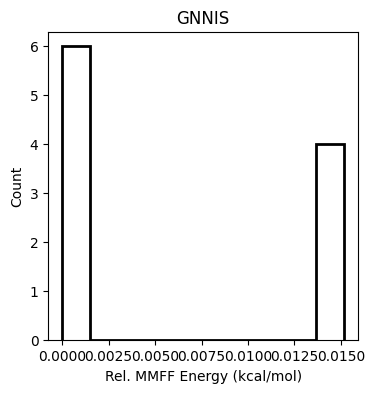

CPU times: user 365 ms, sys: 1.58 s, total: 1.94 s
Wall time: 89.8 ms


In [20]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('GNNIS')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 3: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [21]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 0 ns, sys: 9.81 ms, total: 9.81 ms
Wall time: 40.2 ms


In [22]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 0 ns, sys: 1.78 ms, total: 1.78 ms
Wall time: 1.63 ms


In [23]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 0 ns, sys: 624 µs, total: 624 µs
Wall time: 549 µs


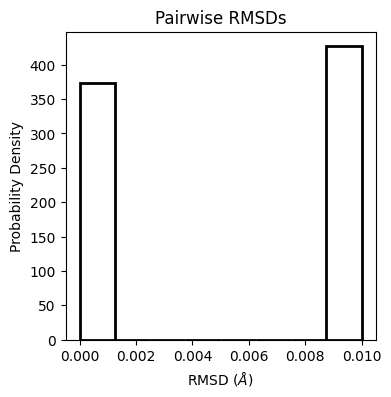

CPU times: user 372 ms, sys: 1.59 s, total: 1.96 s
Wall time: 113 ms


In [24]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [25]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 354 µs, sys: 2.1 ms, total: 2.45 ms
Wall time: 2.33 ms


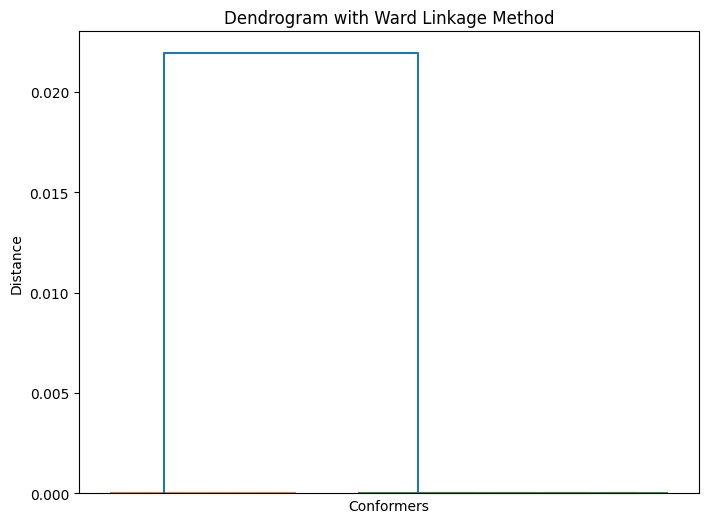

CPU times: user 54.6 ms, sys: 92.5 ms, total: 147 ms
Wall time: 53.3 ms


In [26]:
%%time

### A few settings to export the image of the plot
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))

### Plot the dendrogram to visualize the hierarchical clustering structure
sch.dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrogram with Ward Linkage Method')
plt.xlabel('Conformers')
plt.ylabel('Distance')

### Show the plot
plt.show()

### Save figure
fig.savefig("hierarchical_clustering_dendogram-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

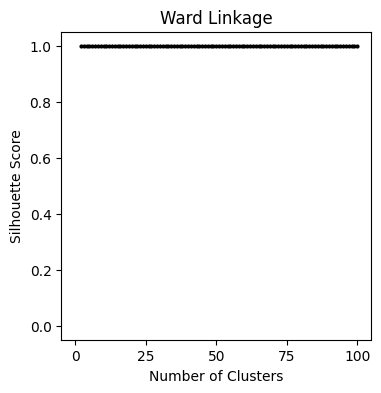

The optimal number of clusters is 2 with a silhouette score of 1.0
CPU times: user 208 ms, sys: 84.3 ms, total: 293 ms
Wall time: 222 ms


In [27]:
%%time

### A few settings to export the image of the plot
# plt.style.use('~/matplotlib_templates/single_column.mplstyle')
fig = plt.figure(figsize=(4, 4))

### Determine the optimal number of clusters using silhouette score; the original pairwise RMSD matrix must be used for this
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter


## Calculate silhouette score for different numbers of clusters
sil_scores = []
range_n_clusters = list(range(2, 101))     # Try different numbers of clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')
    cluster_counts = Counter(cluster_labels)
    # print(cluster_counts)
    
    # Check if the clustering resulted in more than one cluster
    if len(cluster_counts) > 1:
        sil_score = silhouette_score(rmsd_matrix_2DP, cluster_labels, metric='precomputed')
        sil_scores.append(sil_score)
    else:
        sil_scores.append(float('-inf'))  # Append a very low score if there's only one cluster    


## Plot the Silhouette scores
plt.plot(range_n_clusters, sil_scores, marker='o', color='black', fillstyle='none', ms=2, lw=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Ward Linkage")
plt.axis([-5, 105, -0.05, 1.05])
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

### Show the plot
plt.show()

### Save figure
fig.savefig("silhouette_score_vs_num_clust-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## Find the optimal number of clusters based on the maximum value of silhouette score and printing it
max_sil_score = np.max(sil_scores)
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max_sil_score}")

In [28]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters = 5 if optimal_clusters > 5 else optimal_clusters

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 303 µs, sys: 0 ns, total: 303 µs
Wall time: 103 µs


## **Step 5: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [29]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 2.23 ms, sys: 305 µs, total: 2.53 ms
Wall time: 2.2 ms


In [30]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 2.05 ms, sys: 68 µs, total: 2.12 ms
Wall time: 12.2 ms


## **Step 6: Calculating the Minimum RMSD**

Calculating the min rmsd between refrence conformer and cluster representatives.

# calculating the min rmsd between refrence conformer and cluster representatives
result: float = calculate_min_rmsd(f"../{ref_confo_path}",cluster_reps_sdf)
print(f"Min RMSD 20 Clusters: {result}")

# Append the result to the text file
with open('outputs.txt', 'a') as file:
    file.write(f'Min_RMSD_20_cluster : {result}\n')

# Step 7: Geometry optimization of neutral conformers using DFT

In [31]:
!python /work/dft_main.py DFT {cluster_reps_dir} {dielectric_value} 

Found 2 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 46.826
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer()

        # Extract atomic symbols and coordinates
        atom_list =

System: uname_result(system='Linux', node='5d4e56049946', release='6.8.0-60-generic', version='#63-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 19:04:15 UTC 2025', machine='x86_64')  Threads 32
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Mon Aug 18 04:29:25 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'NVIDIA GeForce RTX 4090'
    Device global memory 23.53 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 8
[INPUT] num. electro

Initial guess from minao.


tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000242011602122934
Solvent Energy = -0.000242011602122934
init E= -225.954812796212


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0437474043407467
Solvent Energy = -0.0437474043407467
cycle= 1 E= -225.115097154671  delta_E= 0.84  |ddm|= 3.02


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0144597546403949
Solvent Energy = -0.0144597546403949
cycle= 2 E= -225.016395293512  delta_E= 0.0987  |ddm|= 1.28


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0269952727076884
Solvent Energy = -0.0269952727076884
cycle= 3 E= -225.234139038252  delta_E= -0.218  |ddm|= 0.724


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0265720907927039
Solvent Energy = -0.0265720907927039
cycle= 4 E= -225.234933670771  delta_E= -0.000795  |ddm|= 0.0777


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0268105100741171
Solvent Energy = -0.0268105100741171
cycle= 5 E= -225.235326488087  delta_E= -0.000393  |ddm|= 0.0344


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267135226005736
Solvent Energy = -0.0267135226005736
cycle= 6 E= -225.235332406763  delta_E= -5.92e-06  |ddm|= 0.00802


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267109532132588
Solvent Energy = -0.0267109532132588
cycle= 7 E= -225.235333272973  delta_E= -8.66e-07  |ddm|= 0.00283


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266991388627544
Solvent Energy = -0.0266991388627544
cycle= 8 E= -225.235333374516  delta_E= -1.02e-07  |ddm|= 0.00102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266979802195071
Solvent Energy = -0.0266979802195071
cycle= 9 E= -225.235333382117  delta_E= -7.6e-09  |ddm|= 0.000238


converged SCF energy = -225.235333382117


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1404 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0051075018     0.0152442708    -0.0183817970
1 C     0.0002006852     0.0136878809     0.0094634949
2 N    -0.0069274981     0.0150583375    -0.0178768940
3 O     0.0017242084    -0.0369494509     0.0326311377
4 H     0.0079711700    -0.0053391400     0.0023191006
5 H    -0.0064046385     0.0019114661    -0.0054249915
6 H     0.0059770166     0.0020862739    -0.0058826951
7 H    -0.0076126616    -0.0057004297     0.0031423463
----------------------------------------------
cycle 1: E = -225.235333382  dE = -225.235  norm(grad) = 0.0651706
Step    0 : Gradient = 2.304e-02/4.933e-02 (rms/max) Energy = -225.2353333821
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.59243e-02 ... 5.42103e-01 5.42301e-01 9.93379e-01

Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.100390  -0.063664   0.3

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270549918450367
Solvent Energy = -0.0270549918450367
init E= -225.207184482346


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263935943487919
Solvent Energy = -0.0263935943487919
cycle= 1 E= -225.234591112942  delta_E= -0.0274  |ddm|= 0.382


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0274588393410743
Solvent Energy = -0.0274588393410743
cycle= 2 E= -225.234485809849  delta_E= 0.000105  |ddm|= 0.102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263607814625187
Solvent Energy = -0.0263607814625187
cycle= 3 E= -225.235618515532  delta_E= -0.00113  |ddm|= 0.057


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266847352446142
Solvent Energy = -0.0266847352446142
cycle= 4 E= -225.235664118831  delta_E= -4.56e-05  |ddm|= 0.0119


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266196769711895
Solvent Energy = -0.0266196769711895
cycle= 5 E= -225.235667041272  delta_E= -2.92e-06  |ddm|= 0.00343


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266292677907604
Solvent Energy = -0.0266292677907604
cycle= 6 E= -225.23566726387  delta_E= -2.23e-07  |ddm|= 0.000964


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266311512902019
Solvent Energy = -0.0266311512902019
cycle= 7 E= -225.235667274495  delta_E= -1.06e-08  |ddm|= 0.000239


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.026631058882301
Solvent Energy = -0.026631058882301
cycle= 8 E= -225.235667277361  delta_E= -2.87e-09  |ddm|= 0.000109
converged SCF energy = -225.235667277361


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1441 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0173149368    -0.0106988644     0.0110633430
1 C    -0.0006668930     0.0182983835    -0.0112687616
2 N    -0.0161647853    -0.0112532817     0.0122766678
3 O    -0.0004517386     0.0059811377    -0.0104085363
4 H     0.0030755884    -0.0021644600     0.0017111348
5 H     0.0029366143     0.0010915182    -0.0028404365
6 H    -0.0031873719     0.0009769304    -0.0025812528
7 H    -0.0028544548    -0.0022224984     0.0020317312
----------------------------------------------
cycle 2: E = -225.235667277  dE = -0.000333895  norm(grad) = 0.0418551


Step    1 : Displace = 9.749e-02/1.310e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.480e-02/2.321e-02 (rms/max) E (change) = -225.2356672774 (-3.339e-04) Quality = 0.045
Hessian Eigenvalues: 2.29656e-02 2.30001e-02 2.57809e-02 ... 5.42203e-01 7.49772e-01 1.09210e+00

Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.133078  -0.062042   0.298628   -0.032688  0.001622 -0.001738
   C  -0.018786   0.446590  -0.322734    0.001340 -0.027184  0.025798
   N   1.153276  -0.025871   0.214918    0.032434  0.002713 -0.004248
   O  -0.065259   1.270145  -1.242364    0.001266 -0.028369  0.025268
   H  -1.043396  -0.911864   0.839713   -0.072540  0.002242  0.004900
   H  -1.997268   0.062623  -0.209700   -0.017091  0.021892 -0.023982
   H   1.974022   0.125558  -0.354393    0.014595  0.022510 -0.025333
   H   1.129686  -0.877736   0.759187    0.072640  0.004545 -0.000599
New geometry
   1 N     -1.133077924991  -0.0

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0264140327316649
Solvent Energy = -0.0264140327316649
init E= -225.243403689289


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270367509334357
Solvent Energy = -0.0270367509334357
cycle= 1 E= -225.239027240052  delta_E= 0.00438  |ddm|= 0.123


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263664546372775
Solvent Energy = -0.0263664546372775
cycle= 2 E= -225.239014326505  delta_E= 1.29e-05  |ddm|= 0.04


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.026858277014294
Solvent Energy = -0.026858277014294
cycle= 3 E= -225.239191165737  delta_E= -0.000177  |ddm|= 0.0215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267570834170988
Solvent Energy = -0.0267570834170988
cycle= 4 E= -225.239197175905  delta_E= -6.01e-06  |ddm|= 0.00466


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267696523775909
Solvent Energy = -0.0267696523775909
cycle= 5 E= -225.239197845621  delta_E= -6.7e-07  |ddm|= 0.00156


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267676018111173
Solvent Energy = -0.0267676018111173
cycle= 6 E= -225.239197906095  delta_E= -6.05e-08  |ddm|= 0.00039


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267683428219524
Solvent Energy = -0.0267683428219524
cycle= 7 E= -225.23919790734  delta_E= -1.25e-09  |ddm|= 8.62e-05
converged SCF energy = -225.23919790734


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0017027998    -0.0066528308     0.0060259073
1 C    -0.0002935471     0.0117160001    -0.0042099042
2 N    -0.0010331422    -0.0067381371     0.0061503589
3 O    -0.0002342976     0.0023713593    -0.0060573025
4 H     0.0013599455    -0.0005687524     0.0003527083
5 H     0.0017126092     0.0002269546    -0.0014934747
6 H    -0.0018491384     0.0001587682    -0.0013396529
7 H    -0.0013665737    -0.0005105238     0.0005592621
----------------------------------------------
cycle 3: E = -225.239197907  dE = -0.00353063  norm(grad) = 0.0195039
Step    2 : Displace = 4.783e-02/7.277e-02 (rms/max) Trust = 4.874e-02 (-) Grad = 6.896e-03/1.245e-02 (rms/max) E (change) = -225.2391979073 (-3.531e-03) Quality = 0.894
Hessian Eigenvalues: 2.29729e-02 2.30001e-02 2.59534e-02 ... 5.42203e-01 8.66748e-01 1.15998e+00

Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 

tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0273359069398242
Solvent Energy = -0.0273359069398242
init E= -225.240898712349


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271237082108496
Solvent Energy = -0.0271237082108496
cycle= 1 E= -225.239742170773  delta_E= 0.00116  |ddm|= 0.176


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0267566439556248
Solvent Energy = -0.0267566439556248
cycle= 2 E= -225.239823206661  delta_E= -8.1e-05  |ddm|= 0.0329


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271559058357861
Solvent Energy = -0.0271559058357861
cycle= 3 E= -225.239872957847  delta_E= -4.98e-05  |ddm|= 0.0163


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270177637117294
Solvent Energy = -0.0270177637117294
cycle= 4 E= -225.239888737093  delta_E= -1.58e-05  |ddm|= 0.00619


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270204753406218
Solvent Energy = -0.0270204753406218
cycle= 5 E= -225.239889000319  delta_E= -2.63e-07  |ddm|= 0.00119


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270256202997604
Solvent Energy = -0.0270256202997604
cycle= 6 E= -225.239889032067  delta_E= -3.17e-08  |ddm|= 0.000375


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270253205272366
Solvent Energy = -0.0270253205272366
cycle= 7 E= -225.239889033066  delta_E= -9.99e-10  |ddm|= 7.42e-05
converged SCF energy = -225.239889033066


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0007181591     0.0015886279     0.0029705356
1 C    -0.0002586998    -0.0038710027    -0.0089360780
2 N    -0.0005274668     0.0015750428     0.0029906441
3 O     0.0001476912     0.0008067700     0.0038955849
4 H     0.0009939686    -0.0002083836     0.0000814826
5 H     0.0001151505     0.0001976551    -0.0006552788
6 H    -0.0001592486     0.0001788118    -0.0005660712
7 H    -0.0010391369    -0.0002564648     0.0002135879
----------------------------------------------
cycle 4: E = -225.239889033  dE = -0.000691126  norm(grad) = 0.0117221
Step    3 : Displace = 3.493e-02/4.679e-02 (rms/max) Trust = 6.893e-02 (+) Grad = 4.144e-03/9.742e-03 (rms/max) E (change) = -225.2398890331 (-6.911e-04) Quality = 0.782
Hessian Eigenvalues: 2.25455e-02 2.30001e-02 3.75034e-02 ... 5.42203e-01 7.86195e-01 9.70206e-01

Geometry optimization cycle 5
Cartesian coordinates (Angstrom)


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0266854519029997
Solvent Energy = -0.0266854519029997
init E= -225.242299557267


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270860329676736
Solvent Energy = -0.0270860329676736
cycle= 1 E= -225.239991345188  delta_E= 0.00231  |ddm|= 0.107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0268351784693167
Solvent Energy = -0.0268351784693167
cycle= 2 E= -225.240015015202  delta_E= -2.37e-05  |ddm|= 0.0241


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271005163029755
Solvent Energy = -0.0271005163029755
cycle= 3 E= -225.240049575434  delta_E= -3.46e-05  |ddm|= 0.0113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270270353233787
Solvent Energy = -0.0270270353233787
cycle= 4 E= -225.240053828117  delta_E= -4.25e-06  |ddm|= 0.0035


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027032603044957
Solvent Energy = -0.027032603044957
cycle= 5 E= -225.240053985521  delta_E= -1.57e-07  |ddm|= 0.00088


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027033964711393
Solvent Energy = -0.027033964711393
cycle= 6 E= -225.240054005507  delta_E= -2e-08  |ddm|= 0.000251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270344558821394
Solvent Energy = -0.0270344558821394
cycle= 7 E= -225.240054006062  delta_E= -5.56e-10  |ddm|= 5.38e-05
converged SCF energy = -225.240054006062


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1441 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0014089947     0.0017893496    -0.0013044992
1 C     0.0000474987     0.0013897854     0.0016843676
2 N     0.0012215366     0.0018407440    -0.0014325898
3 O     0.0001664809    -0.0032927812     0.0020676829
4 H     0.0000837016    -0.0004047173    -0.0003956655
5 H    -0.0005519875    -0.0004633946    -0.0001261563
6 H     0.0005844385    -0.0004683013    -0.0000800484
7 H    -0.0001444522    -0.0003880270    -0.0004220139
----------------------------------------------
cycle 5: E = -225.240054006  dE = -0.000164973  norm(grad) = 0.00595964
Step    4 : Displace = 1.773e-02/2.481e-02 (rms/max) Trust = 9.749e-02 (+) Grad = 2.107e-03/3.892e-03 (rms/max) E (change) = -225.2400540061 (-1.650e-04) Quality = 0.560
Hessian Eigenvalues: 2.24728e-02 2.30006e-02 3.39919e-02 ... 5.42202e-01 8.16678e-01 1.12317e+00

Geometry optimization cycle 6
Cartesian coordinates (Angstrom)

tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270636357751377
Solvent Energy = -0.0270636357751377
init E= -225.23760181478


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270296957489583
Solvent Energy = -0.0270296957489583
cycle= 1 E= -225.240119386133  delta_E= -0.00252  |ddm|= 0.0424


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270729999806578
Solvent Energy = -0.0270729999806578
cycle= 2 E= -225.240123626269  delta_E= -4.24e-06  |ddm|= 0.00747


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270171117092147
Solvent Energy = -0.0270171117092147


cycle= 3 E= -225.24012612298  delta_E= -2.5e-06  |ddm|= 0.00359


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270490992915543
Solvent Energy = -0.0270490992915543
cycle= 4 E= -225.240126678402  delta_E= -5.55e-07  |ddm|= 0.00132


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270415590798948
Solvent Energy = -0.0270415590798948
cycle= 5 E= -225.240126719907  delta_E= -4.15e-08  |ddm|= 0.000393


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270434612625943
Solvent Energy = -0.0270434612625943
cycle= 6 E= -225.240126723073  delta_E= -3.17e-09  |ddm|= 0.000116
converged SCF energy = -225.240126723073


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0011051898     0.0002411506     0.0009094888
1 C    -0.0000105724     0.0004124285    -0.0007488593
2 N     0.0011489928     0.0002562352     0.0008306877
3 O    -0.0000060557     0.0000850378    -0.0003019845
4 H    -0.0002772794    -0.0001317955    -0.0003277147
5 H     0.0000737025    -0.0003608230    -0.0000461350
6 H    -0.0000514502    -0.0003689171     0.0000228034
7 H     0.0002204722    -0.0001272764    -0.0003467473
----------------------------------------------
cycle 6: E = -225.240126723  dE = -7.2717e-05  norm(grad) = 0.0023824
Step    5 : Displace = 6.248e-03/9.002e-03 (rms/max) Trust = 9.749e-02 (=) Grad = 8.423e-04/1.451e-03 (rms/max) E (change) = -225.2401267231 (-7.272e-05) Quality = 1.132
Hessian Eigenvalues: 2.24727e-02 2.29864e-02 2.87004e-02 ... 5.53105e-01 7.87620e-01 1.05820e+00

Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027097636715197
Solvent Energy = -0.027097636715197
init E= -225.240983768528


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270504823712264
Solvent Energy = -0.0270504823712264
cycle= 1 E= -225.240145614203  delta_E= 0.000838  |ddm|= 0.0295


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270699365796933
Solvent Energy = -0.0270699365796933
cycle= 2 E= -225.240148014303  delta_E= -2.4e-06  |ddm|= 0.00459


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270838280210623
Solvent Energy = -0.0270838280210623
cycle= 3 E= -225.240148288049  delta_E= -2.74e-07  |ddm|= 0.00147


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270740780479195
Solvent Energy = -0.0270740780479195
cycle= 4 E= -225.240148406884  delta_E= -1.19e-07  |ddm|= 0.000639


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270804070494158
Solvent Energy = -0.0270804070494158
cycle= 5 E= -225.240148417212  delta_E= -1.03e-08  |ddm|= 0.000243


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0270795487664578
Solvent Energy = -0.0270795487664578
cycle= 6 E= -225.24014841936  delta_E= -2.15e-09  |ddm|= 7.47e-05
converged SCF energy = -225.24014841936


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000647859     0.0004039425     0.0008490112
1 C    -0.0000242698    -0.0000266646    -0.0011807634
2 N    -0.0000315955     0.0003762473     0.0008776600
3 O     0.0000134900     0.0000090976     0.0001531553
4 H    -0.0000963983    -0.0002277602    -0.0001589153
5 H    -0.0000388625    -0.0001420251    -0.0002250618
6 H     0.0000343249    -0.0001376522    -0.0001799442
7 H     0.0000698862    -0.0002475170    -0.0001425165
----------------------------------------------
cycle 7: E = -225.240148419  dE = -2.16963e-05  norm(grad) = 0.00187563
Step    6 : Displace = 3.800e-03/4.938e-03 (rms/max) Trust = 1.379e-01 (+) Grad = 6.631e-04/1.181e-03 (rms/max) E (change) = -225.2401484194 (-2.170e-05) Quality = 1.509
Hessian Eigenvalues: 9.54357e-03 2.24755e-02 2.30151e-02 ... 5.44812e-01 9.08321e-01 1.19189e+00

Geometry optimization cycle 8
Cartesian coordinates (Angstrom)

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271227451412423
Solvent Energy = -0.0271227451412423
init E= -225.241598964027


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271226851347039
Solvent Energy = -0.0271226851347039
cycle= 1 E= -225.240163014072  delta_E= 0.00144  |ddm|= 0.0685


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027104993643913
Solvent Energy = -0.027104993643913
cycle= 2 E= -225.24017437784  delta_E= -1.14e-05  |ddm|= 0.0101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271892200063186
Solvent Energy = -0.0271892200063186
cycle= 3 E= -225.240175915949  delta_E= -1.54e-06  |ddm|= 0.00401


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271487227138752
Solvent Energy = -0.0271487227138752
cycle= 4 E= -225.240177234679  delta_E= -1.32e-06  |ddm|= 0.00179


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271563664574655


Solvent Energy = -0.0271563664574655
cycle= 5 E= -225.240177267383  delta_E= -3.27e-08  |ddm|= 0.000525


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271571825965684
Solvent Energy = -0.0271571825965684
cycle= 6 E= -225.240177271554  delta_E= -4.17e-09  |ddm|= 0.00013
converged SCF energy = -225.240177271554


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0008055448     0.0003109360     0.0005161823
1 C    -0.0000195928    -0.0005489718    -0.0006748589
2 N    -0.0007966532     0.0002536986     0.0006263215
3 O     0.0000127151     0.0002623451    -0.0000225618
4 H    -0.0000242249    -0.0001490606    -0.0000630090
5 H    -0.0000080595     0.0000167403    -0.0001869612
6 H     0.0000014748     0.0000213535    -0.0001594659
7 H     0.0000197548    -0.0001580088    -0.0000404125
----------------------------------------------
cycle 8: E = -225.240177272  dE = -2.88522e-05  norm(grad) = 0.00174498
Step    7 : Displace = 7.848e-03/1.128e-02 (rms/max) Trust = 1.950e-01 (+) Grad = 6.169e-04/1.045e-03 (rms/max) E (change) = -225.2401772716 (-2.885e-05) Quality = 1.409
Hessian Eigenvalues: 5.18363e-03 2.26017e-02 2.30108e-02 ... 5.59605e-01 9.08929e-01 1.25292e+00

Geometry optimization cycle 9
Cartesian coordinates (Angstrom)

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271671920720722
Solvent Energy = -0.0271671920720722
init E= -225.241458305072


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271885839210716
Solvent Energy = -0.0271885839210716
cycle= 1 E= -225.240180867612  delta_E= 0.00128  |ddm|= 0.06


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271622749858827
Solvent Energy = -0.0271622749858827
cycle= 2 E= -225.240189587072  delta_E= -8.72e-06  |ddm|= 0.00884


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027237062530008
Solvent Energy = -0.027237062530008
cycle= 3 E= -225.240190936333  delta_E= -1.35e-06  |ddm|= 0.00355


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272008218432304
Solvent Energy = -0.0272008218432304
cycle= 4 E= -225.240191921897  delta_E= -9.86e-07  |ddm|= 0.00157


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272072231798084
Solvent Energy = -0.0272072231798084
cycle= 5 E= -225.240191947524  delta_E= -2.56e-08  |ddm|= 0.000458


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272076327094599
Solvent Energy = -0.0272076327094599
cycle= 6 E= -225.240191952035  delta_E= -4.51e-09  |ddm|= 0.000128
converged SCF energy = -225.240191952035


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0006089062     0.0002047627     0.0000875817
1 C     0.0000054066    -0.0005642146     0.0000636360
2 N    -0.0006139730     0.0001696168     0.0001852897
3 O    -0.0000017644     0.0002491747    -0.0001764604
4 H     0.0000056066    -0.0000630010    -0.0000186396
5 H    -0.0000041899     0.0000398966    -0.0000844144
6 H    -0.0000044789     0.0000319765    -0.0000635245
7 H    -0.0000031384    -0.0000607367     0.0000046133
----------------------------------------------
cycle 9: E = -225.240191952  dE = -1.46805e-05  norm(grad) = 0.00113928
Step    8 : Displace = 6.654e-03/1.000e-02 (rms/max) Trust = 2.757e-01 (+) Grad = 4.028e-04/6.634e-04 (rms/max) E (change) = -225.2401919520 (-1.468e-05) Quality = 1.329
Hessian Eigenvalues: 3.91315e-03 2.25648e-02 2.30066e-02 ... 5.64712e-01 9.06060e-01 1.13626e+00

Geometry optimization cycle 10
Cartesian coordinates (Angstrom

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027200516353631
Solvent Energy = -0.027200516353631
init E= -225.240864847527


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272030114356728
Solvent Energy = -0.0272030114356728
cycle= 1 E= -225.24019263142  delta_E= 0.000672  |ddm|= 0.0282


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271971845077244
Solvent Energy = -0.0271971845077244
cycle= 2 E= -225.240194741973  delta_E= -2.11e-06  |ddm|= 0.00405


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272184108831049
Solvent Energy = -0.0272184108831049
cycle= 3 E= -225.240194988104  delta_E= -2.46e-07  |ddm|= 0.00137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027205739309362
Solvent Energy = -0.027205739309362
cycle= 4 E= -225.24019510786  delta_E= -1.2e-07  |ddm|= 0.000612


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272096412628359
Solvent Energy = -0.0272096412628359
cycle= 5 E= -225.240195115208  delta_E= -7.35e-09  |ddm|= 0.000214
converged SCF energy = -225.240195115208


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1442 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0001549797     0.0000598983    -0.0000345830
1 C     0.0000081138    -0.0002538844     0.0001903015
2 N    -0.0001595446     0.0000613368     0.0000045814
3 O    -0.0000015963     0.0001354821    -0.0001557941
4 H    -0.0000005644    -0.0000100756     0.0000010337
5 H    -0.0000037018     0.0000121028    -0.0000206580
6 H     0.0000014944     0.0000016785    -0.0000011908
7 H    -0.0000059659    -0.0000003664     0.0000162237
----------------------------------------------
cycle 10: E = -225.240195115  dE = -3.16317e-06  norm(grad) = 0.000449892


Step    9 : Displace = 3.106e-03/4.693e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 1.591e-04/3.174e-04 (rms/max) E (change) = -225.2401951152 (-3.163e-06) Quality = 1.245
Hessian Eigenvalues: 3.51297e-03 2.24143e-02 2.29741e-02 ... 5.42353e-01 9.17265e-01 1.08085e+00

Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.140378  -0.098633   0.278932    0.000254 -0.001179  0.000236
   C  -0.023873   0.398331  -0.327478   -0.000261 -0.000039  0.000044
   N   1.168016  -0.048843   0.163425    0.000386 -0.000692 -0.001905
   O  -0.086745   1.249469  -1.223341   -0.001257  0.000719  0.000966
   H  -1.090140  -0.917667   0.867722    0.000846 -0.000407  0.001183
   H  -2.026189   0.109341  -0.158069   -0.000447 -0.000209  0.002209
   H   1.995760   0.195481  -0.360065    0.000217  0.000926 -0.001350
   H   1.212360  -0.868911   0.751166    0.001288 -0.000060 -0.001141
New geometry
   1 N     -1.140377942893  -0.

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272061777301669
Solvent Energy = -0.0272061777301669
init E= -225.240448418303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271968649639688
Solvent Energy = -0.0271968649639688
cycle= 1 E= -225.240195264903  delta_E= 0.000253  |ddm|= 0.00701


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272037729285378
Solvent Energy = -0.0272037729285378
cycle= 2 E= -225.240195428821  delta_E= -1.64e-07  |ddm|= 0.00115


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0271976679246703
Solvent Energy = -0.0271976679246703
cycle= 3 E= -225.240195455852  delta_E= -2.7e-08  |ddm|= 0.000426


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272006376262008
Solvent Energy = -0.0272006376262008
cycle= 4 E= -225.240195467311  delta_E= -1.15e-08  |ddm|= 0.00019


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027199676387494
Solvent Energy = -0.027199676387494
cycle= 5 E= -225.240195467912  delta_E= -6e-10  |ddm|= 6.35e-05
converged SCF energy = -225.240195467912


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1441 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000064424     0.0000037563    -0.0000427021
1 C    -0.0000011075    -0.0000622626     0.0000935401
2 N    -0.0000119889     0.0000192974    -0.0000232602
3 O     0.0000031051     0.0000245031    -0.0000597139
4 H    -0.0000028723     0.0000113473     0.0000052312
5 H     0.0000011589     0.0000011237    -0.0000058141
6 H     0.0000051592    -0.0000045978     0.0000115674
7 H    -0.0000065662     0.0000125873     0.0000218297
----------------------------------------------
cycle 11: E = -225.240195468  dE = -3.52704e-07  norm(grad) = 0.000144222
Step   10 : Displace = 7.252e-04/1.126e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 5.099e-05/1.124e-04 (rms/max) E (change) = -225.2401954679 (-3.527e-07) Quality = 1.484
Hessian Eigenvalues: 3.51297e-03 2.24143e-02 2.29741e-02 ... 5.42353e-01 9.17265e-01 1.08085e+00
Converged! =D

    #=========================================

Initial guess from minao.


tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000241139268856794
Solvent Energy = -0.000241139268856794
init E= -225.877234598699


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0442467145925836
Solvent Energy = -0.0442467145925836
cycle= 1 E= -225.120321857195  delta_E= 0.757  |ddm|= 3.06


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.014174373522843
Solvent Energy = -0.014174373522843
cycle= 2 E= -225.010641590918  delta_E= 0.11  |ddm|= 1.27


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0277417475567537
Solvent Energy = -0.0277417475567537
cycle= 3 E= -225.238913982322  delta_E= -0.228  |ddm|= 0.731


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0269595367243407
Solvent Energy = -0.0269595367243407
cycle= 4 E= -225.239801155574  delta_E= -0.000887  |ddm|= 0.0782


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0273238130710989
Solvent Energy = -0.0273238130710989
cycle= 5 E= -225.240189539608  delta_E= -0.000388  |ddm|= 0.0323


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272143111887832
Solvent Energy = -0.0272143111887832
cycle= 6 E= -225.24019449869  delta_E= -4.96e-06  |ddm|= 0.00645


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.027215966564748
Solvent Energy = -0.027215966564748
cycle= 7 E= -225.240195344264  delta_E= -8.46e-07  |ddm|= 0.00236


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272021667604358
Solvent Energy = -0.0272021667604358
cycle= 8 E= -225.240195460094  delta_E= -1.16e-07  |ddm|= 0.000979


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0272007358734567
Solvent Energy = -0.0272007358734567
cycle= 9 E= -225.240195467926  delta_E= -7.83e-09  |ddm|= 0.000233
converged SCF energy = -225.240195467926
**** MO energy ****
MO #1   energy= -19.6074258154426  occ= 2
MO #2   energy= -14.7732552648192  occ= 2
MO #3   energy= -14.7732144374373  occ= 2
MO #4   energy= -10.6840567376612  occ= 2
MO #5   energy= -1.16960765040519  occ= 2
MO #6   energy= -1.02843613779661  occ= 2
MO #7   energy= -0.981376965618896 occ= 2
MO #8   energy= -0.697016135945548 occ= 2
MO #9   energy= -0.623340061855283 occ= 2
MO #10  energy= -0.613551377921891 occ= 2
MO #11  energy= -0.53616329750542  occ= 2
MO #12  energy= -0.514351566632667 occ= 2
MO #13  energy= -0.499681419472921 occ= 2
MO #14  energy= -0.3540805723097   occ= 2
MO #15  energy= -0.341135829843952 occ= 2
MO #16  energy= -0.33463825043493  occ= 2
MO #17  energy= -0.00163471541967676 occ= 0
MO #18  energy= 0.0182028566135569 occ= 0
MO #19  ener

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 N 1s            1.99996
pop of  0 N 2s            1.24608
pop of  0 N 3s            0.00354
pop of  0 N 4s            0.00156
pop of  0 N 2px           1.20821
pop of  0 N 2py           1.46032
pop of  0 N 2pz           1.49825
pop of  0 N 3px           0.00358
pop of  0 N 3py           0.00879
pop of  0 N 3pz           0.00955
pop of  0 N 4px           0.00120
pop of  0 N 4py           0.00087
pop of  0 N 4pz           0.00101
pop of  0 N 3dxy          0.00042
pop of  0 N 3dyz          0.00151
pop of  0 N 3dz^2         0.00055
pop of  0 N 3dxz          0.00111
pop of  0 N 3dx2-y2       0.00114
pop of  0 N 4dxy          0.00049
pop of  0 N 4dyz          0.00135
pop of  0 N 4dz^2         0.00066
pop of  0 N 4dxz          0.00087
pop of  0 N 4dx2-y2       0.00187
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.84987
pop of  1 C 3s            0.00812
pop of  1 C 4s            0.00246
pop of  1 

Dipole moment(X, Y, Z, Debye):  0.27094, -5.04053,  3.30991
Optimized geometry saved to 'cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz'.
Final energy: -225.24019547 Hartree (-141340.249818 kcal/mol)

OPT Time: 21.24 seconds
################################################################
Finished rep_of_cluster_1.sdf | basis: aug-cc-pVDZ | xc: M06-2X in 21.33 s
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, remov

Initial guess from minao.


tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000244029023661224
Solvent Energy = -0.000244029023661224
init E= -225.95451288101


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0424359235371334
Solvent Energy = -0.0424359235371334
cycle= 1 E= -225.116456050206  delta_E= 0.838  |ddm|= 3.04


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0131337022143114
Solvent Energy = -0.0131337022143114
cycle= 2 E= -225.017639747029  delta_E= 0.0988  |ddm|= 1.29


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259230438527143
Solvent Energy = -0.0259230438527143
cycle= 3 E= -225.235390981954  delta_E= -0.218  |ddm|= 0.73


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0253346620225916
Solvent Energy = -0.0253346620225916
cycle= 4 E= -225.236174196028  delta_E= -0.000783  |ddm|= 0.0773


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255926860397277
Solvent Energy = -0.0255926860397277
cycle= 5 E= -225.236566388183  delta_E= -0.000392  |ddm|= 0.0349


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255003114239918
Solvent Energy = -0.0255003114239918
cycle= 6 E= -225.236572603277  delta_E= -6.22e-06  |ddm|= 0.00826


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0254944183077921
Solvent Energy = -0.0254944183077921
cycle= 7 E= -225.236573475607  delta_E= -8.72e-07  |ddm|= 0.00287


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0254821086574775
Solvent Energy = -0.0254821086574775
cycle= 8 E= -225.236573581312  delta_E= -1.06e-07  |ddm|= 0.00102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0254813554028519
Solvent Energy = -0.0254813554028519
cycle= 9 E= -225.236573587928  delta_E= -6.62e-09  |ddm|= 0.000214
converged SCF energy = -225.236573587928


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1449 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0036857523     0.0239824420     0.0033579058
1 C     0.0000967436     0.0007990421     0.0000065879
2 N     0.0085193964     0.0224737236    -0.0046414292
3 O    -0.0049900942    -0.0482023239     0.0013225936
4 H    -0.0078526268    -0.0045098015    -0.0019759167
5 H     0.0066360335     0.0050236148    -0.0010637042
6 H     0.0067799643    -0.0058998793     0.0022334688
7 H    -0.0054883850     0.0063276383     0.0007722404
----------------------------------------------
cycle 1: E = -225.236573588  dE = -225.237  norm(grad) = 0.0621515
Step    0 : Gradient = 2.197e-02/4.848e-02 (rms/max) Energy = -225.2365735879
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.59273e-02 ... 5.42536e-01 5.42549e-01 9.93152e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.081321  -0.339842   0.035493   -0.061779 -0.008742  0.002493
   C   0.059629   0.570253  -0.016243    0.010929  0.106053 -0.003043
   N  -1.126910  -0.113004  -0.023965    0.058490 -0.021104 -0.001765
   O   0.186629   1.798505  -0.050125    0.013529  0.129805 -0.003725
   H   0.881961  -1.296625  -0.232571   -0.117039  0.004275  0.013629
   H   1.986954   0.027187  -0.224502   -0.029846 -0.092813  0.011598
   H  -1.125929  -1.074334   0.296721    0.115071 -0.020234 -0.013079
   H  -1.936653   0.445142   0.211110    0.010147 -0.097058 -0.006490
New geometry
   1 N      1.081320972015  -0.339841922523   0.035492947674 AA    2.043400489857  -0.642208159215   0.067071950458 Bohr

   2 C      0.059629117125   0.570253362441  -0.016243460550 AA    0.112682700416   1.077622676626  -0.030695691755 Bohr

   3 N     -1.126910091997  -0.113004476801  -0.0239647

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0252374362624684
Solvent Energy = -0.0252374362624684
init E= -225.212213894955


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.025006349957866
Solvent Energy = -0.025006349957866
cycle= 1 E= -225.235257191674  delta_E= -0.023  |ddm|= 0.364


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0261044241676597
Solvent Energy = -0.0261044241676597
cycle= 2 E= -225.235125189703  delta_E= 0.000132  |ddm|= 0.0957


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0249711833532105
Solvent Energy = -0.0249711833532105
cycle= 3 E= -225.236186401335  delta_E= -0.00106  |ddm|= 0.055


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0252797145717309
Solvent Energy = -0.0252797145717309
cycle= 4 E= -225.236229984911  delta_E= -4.36e-05  |ddm|= 0.0109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0252309704238822
Solvent Energy = -0.0252309704238822
cycle= 5 E= -225.236231411607  delta_E= -1.43e-06  |ddm|= 0.00264


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0252406274904428
Solvent Energy = -0.0252406274904428
cycle= 6 E= -225.236231597991  delta_E= -1.86e-07  |ddm|= 0.000813


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0252418229800282
Solvent Energy = -0.0252418229800282
cycle= 7 E= -225.236231604535  delta_E= -6.54e-09  |ddm|= 0.000187
converged SCF energy = -225.236231604535


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1449 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0191212120    -0.0132517176     0.0016348985
1 C     0.0019976436     0.0192052051    -0.0005168464
2 N     0.0160325361    -0.0169660265    -0.0008140773
3 O     0.0011403588     0.0110543348    -0.0002977531
4 H    -0.0030128911    -0.0028421086     0.0001390737
5 H    -0.0023504455     0.0033518885    -0.0004130392
6 H     0.0023150522    -0.0033629247     0.0000217110
7 H     0.0030011035     0.0028215388     0.0002523772
----------------------------------------------
cycle 2: E = -225.236231605  dE = 0.000341983  norm(grad) = 0.0406687
Step    1 : Displace = 1.019e-01/1.305e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.438e-02/2.336e-02 (rms/max) E (change) = -225.2362316045 (+3.420e-04) Quality = -0.051
Hessian Eigenvalues: 2.30000e-02 2.30155e-02 2.59273e-02 ... 5.42543e-01 7.55011e-01 1.09144e+00



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.119501  -0.340090   0.030224    0.038180 -0.000248 -0.005269
   C   0.055192   0.527548  -0.015078   -0.004437 -0.042705  0.001166
   N  -1.164323  -0.105176  -0.018918   -0.037412  0.007828  0.005046
   O   0.182223   1.756091  -0.048968   -0.004406 -0.042414  0.001157
   H   0.964150  -1.303977  -0.235066    0.082189 -0.007352 -0.002495
   H   2.007913   0.062780  -0.234044    0.020959  0.035593 -0.009542
   H  -1.207821  -1.064608   0.299158   -0.081892  0.009727  0.002437
   H  -1.949873   0.484676   0.218558   -0.013220  0.039535  0.007448
New geometry
   1 N      1.119501355024  -0.340089880417   0.030223555280 AA    2.115550957074  -0.642676731724   0.057114241990 Bohr

   2 C      0.055191809014   0.527548262630  -0.015077601638 AA    0.104297403356   0.996921733861  -0.028492537711 Bohr

   3 N     -1.164322577860  -0.105176386567  -0.0189183

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0250828512609233
Solvent Energy = -0.0250828512609233
init E= -225.242161917191


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257978321825632
Solvent Energy = -0.0257978321825632
cycle= 1 E= -225.23962462377  delta_E= 0.00254  |ddm|= 0.154


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0250666035608299
Solvent Energy = -0.0250666035608299
cycle= 2 E= -225.239626672001  delta_E= -2.05e-06  |ddm|= 0.0456


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0256291733406162
Solvent Energy = -0.0256291733406162
cycle= 3 E= -225.239833115576  delta_E= -0.000206  |ddm|= 0.0237


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255020057495801
Solvent Energy = -0.0255020057495801
cycle= 4 E= -225.239842205651  delta_E= -9.09e-06  |ddm|= 0.00572


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255162935859117
Solvent Energy = -0.0255162935859117
cycle= 5 E= -225.23984310396  delta_E= -8.98e-07  |ddm|= 0.00183


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255144559248431
Solvent Energy = -0.0255144559248431
cycle= 6 E= -225.239843189935  delta_E= -8.6e-08  |ddm|= 0.000461


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255153221884163
Solvent Energy = -0.0255153221884163
cycle= 7 E= -225.239843191927  delta_E= -1.99e-09  |ddm|= 0.000108
converged SCF energy = -225.239843191927


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1449 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0003297444    -0.0073943318     0.0008126035
1 C     0.0008074836     0.0077277201    -0.0001949319
2 N    -0.0012480030    -0.0073446123    -0.0004330614
3 O     0.0005972620     0.0057918814    -0.0001533551
4 H    -0.0014448618    -0.0003543495     0.0000321009
5 H    -0.0012626216     0.0012675937    -0.0000648127
6 H     0.0013819661    -0.0006797318     0.0000049088
7 H     0.0015075536     0.0009888603     0.0000087460
----------------------------------------------
cycle 3: E = -225.239843192  dE = -0.00361159  norm(grad) = 0.0147143
Step    2 : Displace = 5.460e-02/8.256e-02 (rms/max) Trust = 5.000e-02 (-) Grad = 5.202e-03/7.772e-03 (rms/max) E (change) = -225.2398431919 (-3.612e-03) Quality = 0.892
Hessian Eigenvalues: 2.30000e-02 2.30186e-02 2.59273e-02 ... 5.42543e-01 8.59473e-01 1.10623e+00



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.129090  -0.337577   0.025686    0.009588  0.002513 -0.004538
   C   0.053467   0.508594  -0.014717   -0.001725 -0.018954  0.000360
   N  -1.173373  -0.099183  -0.014714   -0.009050  0.005993  0.004204
   O   0.180858   1.734319  -0.048725   -0.001365 -0.021772  0.000243
   H   0.996120  -1.306978  -0.232059    0.031969 -0.003001  0.003007
   H   2.013716   0.076301  -0.236934    0.005802  0.013521 -0.002890
   H  -1.241453  -1.059675   0.296008   -0.033632  0.004933 -0.003150
   H  -1.952446   0.501412   0.220104   -0.002573  0.016736  0.001546
New geometry
   1 N      1.129089598965  -0.337576737292   0.025685535480 AA    2.133670112139  -0.637927579506   0.048538627420 Bohr

   2 C      0.053466690069   0.508593929951  -0.014717225381 AA    0.101037401018   0.961103236224  -0.027811525284 Bohr

   3 N     -1.173373015665  -0.099182932850  -0.0147143

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0256761654600139
Solvent Energy = -0.0256761654600139
init E= -225.246204981641


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257951532004646
Solvent Energy = -0.0257951532004646
cycle= 1 E= -225.240218729824  delta_E= 0.00599  |ddm|= 0.0711


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0255555751812987
Solvent Energy = -0.0255555751812987
cycle= 2 E= -225.240212057646  delta_E= 6.67e-06  |ddm|= 0.0207


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0258058204986502
Solvent Energy = -0.0258058204986502
cycle= 3 E= -225.240258643438  delta_E= -4.66e-05  |ddm|= 0.0113


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257548503463221
Solvent Energy = -0.0257548503463221
cycle= 4 E= -225.24026022041  delta_E= -1.58e-06  |ddm|= 0.0021


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257648496966236
Solvent Energy = -0.0257648496966236
cycle= 5 E= -225.240260257826  delta_E= -3.74e-08  |ddm|= 0.000473


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257638118315681
Solvent Energy = -0.0257638118315681
cycle= 6 E= -225.240260262124  delta_E= -4.3e-09  |ddm|= 0.000124
converged SCF energy = -225.240260262124


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1449 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000764288    -0.0003260262     0.0009836317
1 C     0.0003113782     0.0028523690    -0.0000666094
2 N    -0.0001207601    -0.0003947666    -0.0009727311
3 O    -0.0002778573    -0.0026084297     0.0000774983
4 H    -0.0006784434    -0.0002483374    -0.0003379847
5 H     0.0000914686     0.0005271403    -0.0003096560
6 H     0.0005968586    -0.0003296897     0.0003485954
7 H     0.0000165735     0.0005291573     0.0002928119
----------------------------------------------
cycle 4: E = -225.240260262  dE = -0.00041707  norm(grad) = 0.00439222
Step    3 : Displace = 2.180e-02/3.313e-02 (rms/max) Trust = 7.071e-02 (+) Grad = 1.553e-03/2.870e-03 (rms/max) E (change) = -225.2402602621 (-4.171e-04) Quality = 1.084


Hessian Eigenvalues: 2.30000e-02 2.30209e-02 2.59273e-02 ... 5.42543e-01 8.08920e-01 1.14981e+00

Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.130837  -0.337210   0.020731    0.001747  0.000367 -0.004955
   C   0.053194   0.506973  -0.014977   -0.000273 -0.001621 -0.000260
   N  -1.175453  -0.097615  -0.010116   -0.002080  0.001568  0.004598
   O   0.181100   1.734581  -0.049144    0.000241  0.000262 -0.000419
   H   1.005806  -1.309216  -0.228580    0.009686 -0.002237  0.003478
   H   2.016319   0.076175  -0.237334    0.002603 -0.000126 -0.000400
   H  -1.252162  -1.059447   0.292447   -0.010709  0.000228 -0.003561
   H  -1.955197   0.502849   0.220079   -0.002751  0.001437 -0.000026
New geometry
   1 N      1.130836765691  -0.337209575237   0.020731035254 AA    2.136971778745  -0.637233743779   0.039175978908 Bohr

   2 C      0.053193861481   0.506972739506  -0.014977033084 AA    0.10052182970

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0257268477356276
Solvent Energy = -0.0257268477356276
init E= -225.239668501992


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259516632391761
Solvent Energy = -0.0259516632391761
cycle= 1 E= -225.240286287681  delta_E= -0.000618  |ddm|= 0.0379


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0258333011261122
Solvent Energy = -0.0258333011261122
cycle= 2 E= -225.240287678447  delta_E= -1.39e-06  |ddm|= 0.00768


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259340503314179
Solvent Energy = -0.0259340503314179
cycle= 3 E= -225.240292246131  delta_E= -4.57e-06  |ddm|= 0.00382


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259130966925084
Solvent Energy = -0.0259130966925084
cycle= 4 E= -225.240292648137  delta_E= -4.02e-07  |ddm|= 0.00114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259166058886567
Solvent Energy = -0.0259166058886567
cycle= 5 E= -225.240292677009  delta_E= -2.89e-08  |ddm|= 0.000385


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259169014710284
Solvent Energy = -0.0259169014710284
cycle= 6 E= -225.240292680181  delta_E= -3.17e-09  |ddm|= 0.000137
converged SCF energy = -225.240292680181


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1450 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0009118183    -0.0004541268     0.0006924001
1 C     0.0001156508     0.0010857777    -0.0000387637
2 N    -0.0009690301    -0.0003023975    -0.0006781075
3 O    -0.0000366899    -0.0003312927     0.0000213230
4 H     0.0001427865     0.0001158164    -0.0002871002
5 H    -0.0000704839    -0.0001271352    -0.0002318804
6 H    -0.0001236572     0.0001533204     0.0002871731
7 H     0.0000442641    -0.0001380733     0.0002517161
----------------------------------------------
cycle 5: E = -225.24029268  dE = -3.24181e-05  norm(grad) = 0.00217013


Step    4 : Displace = 6.239e-03/1.082e-02 (rms/max) Trust = 1.000e-01 (+) Grad = 7.673e-04/1.232e-03 (rms/max) E (change) = -225.2402926802 (-3.242e-05) Quality = 1.179
Hessian Eigenvalues: 2.13861e-02 2.30008e-02 2.31538e-02 ... 5.42545e-01 9.17227e-01 1.22033e+00

Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.130092  -0.336485   0.015675   -0.000744  0.000725 -0.005056
   C   0.053025   0.506655  -0.015257   -0.000168 -0.000317 -0.000280
   N  -1.175138  -0.096086  -0.005554    0.000315  0.001529  0.004562
   O   0.181366   1.734927  -0.049717    0.000266  0.000346 -0.000573
   H   1.007126  -1.311069  -0.223822    0.001321 -0.001854  0.004759
   H   2.017455   0.075647  -0.237558    0.001136 -0.000527 -0.000225
   H  -1.254832  -1.060491   0.287455   -0.002670 -0.001045 -0.004992
   H  -1.956742   0.503742   0.219569   -0.001545  0.000893 -0.000510
New geometry
   1 N      1.130092431682  -0.3

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0259208260811191
Solvent Energy = -0.0259208260811191
init E= -225.241183968395


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.026068971867461
Solvent Energy = -0.026068971867461
cycle= 1 E= -225.240307047754  delta_E= 0.000877  |ddm|= 0.0343


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0260051396825286
Solvent Energy = -0.0260051396825286
cycle= 2 E= -225.240308402996  delta_E= -1.36e-06  |ddm|= 0.00606


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0260802887582832
Solvent Energy = -0.0260802887582832
cycle= 3 E= -225.240310199522  delta_E= -1.8e-06  |ddm|= 0.00291


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0260620906236265
Solvent Energy = -0.0260620906236265
cycle= 4 E= -225.240310603814  delta_E= -4.04e-07  |ddm|= 0.000999


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0260633935227639
Solvent Energy = -0.0260633935227639
cycle= 5 E= -225.240310612131  delta_E= -8.32e-09  |ddm|= 0.000291
converged SCF energy = -225.240310612131


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1451 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0003693910     0.0000413245     0.0005372706
1 C     0.0000070023     0.0000483630     0.0000190976
2 N    -0.0003608638     0.0000895932    -0.0005638207
3 O    -0.0000001770     0.0000017396     0.0000004087
4 H     0.0002686222     0.0000749627    -0.0002594192
5 H     0.0000729500    -0.0002045582    -0.0002070689
6 H    -0.0002326806     0.0001269996     0.0002618829
7 H    -0.0001092037    -0.0001768833     0.0002282672
----------------------------------------------
cycle 6: E = -225.240310612  dE = -1.7932e-05  norm(grad) = 0.00116405
Step    5 : Displace = 3.767e-03/5.307e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 4.116e-04/6.754e-04 (rms/max) E (change) = -225.2403106121 (-1.793e-05) Quality = 1.609
Hessian Eigenvalues: 7.92165e-03 2.30004e-02 2.32103e-02 ... 5.42547e-01 9.25525e-01 1.13258e+00

Geometry optimization cycle 7
Cartesian coordinates (Angstrom)


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0260614939913101
Solvent Energy = -0.0260614939913101
init E= -225.242266705165


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.026305689050584
Solvent Energy = -0.026305689050584
cycle= 1 E= -225.240318741693  delta_E= 0.00195  |ddm|= 0.0685


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0262206849514561
Solvent Energy = -0.0262206849514561
cycle= 2 E= -225.240326790539  delta_E= -8.05e-06  |ddm|= 0.0108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263403319486587
Solvent Energy = -0.0263403319486587
cycle= 3 E= -225.24032939353  delta_E= -2.6e-06  |ddm|= 0.00467


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0262995100461485
Solvent Energy = -0.0262995100461485
cycle= 4 E= -225.240331034801  delta_E= -1.64e-06  |ddm|= 0.00194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263030194796539
Solvent Energy = -0.0263030194796539
cycle= 5 E= -225.240331064218  delta_E= -2.94e-08  |ddm|= 0.000558


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263045297971077
Solvent Energy = -0.0263045297971077
cycle= 6 E= -225.240331068123  delta_E= -3.91e-09  |ddm|= 0.000135
converged SCF energy = -225.240331068123


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1451 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0003695796     0.0003981027     0.0002070686
1 C    -0.0000788007    -0.0008875312    -0.0000120328
2 N     0.0004110025     0.0003012078    -0.0002234143
3 O     0.0000459729     0.0004264724     0.0000097159
4 H     0.0001924120     0.0000029960    -0.0001319569
5 H     0.0000838770    -0.0001511296    -0.0000794015
6 H    -0.0001586667     0.0000365912     0.0001379599
7 H    -0.0001105749    -0.0001255955     0.0001048539
----------------------------------------------
cycle 7: E = -225.240331068  dE = -2.0456e-05  norm(grad) = 0.00134195
Step    6 : Displace = 7.719e-03/1.127e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 4.745e-04/8.911e-04 (rms/max) E (change) = -225.2403310681 (-2.046e-05) Quality = 1.221
Hessian Eigenvalues: 5.92397e-03 2.30006e-02 2.32861e-02 ... 5.62055e-01 9.13135e-01 1.13052e+00

Geometry optimization cycle 8
Cartesian coordinates (Angstrom)


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0262926925194231
Solvent Energy = -0.0262926925194231
init E= -225.241203477888


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263557157978947
Solvent Energy = -0.0263557157978947
cycle= 1 E= -225.240332628158  delta_E= 0.000871  |ddm|= 0.0255


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263428348876892
Solvent Energy = -0.0263428348876892
cycle= 2 E= -225.24033403671  delta_E= -1.41e-06  |ddm|= 0.00372


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263646881744622
Solvent Energy = -0.0263646881744622
cycle= 3 E= -225.240334133249  delta_E= -9.65e-08  |ddm|= 0.00109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263539161372532
Solvent Energy = -0.0263539161372532
cycle= 4 E= -225.240334214116  delta_E= -8.09e-08  |ddm|= 0.000485


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263566368679741
Solvent Energy = -0.0263566368679741
cycle= 5 E= -225.240334218949  delta_E= -4.83e-09  |ddm|= 0.000184
converged SCF energy = -225.240334218949


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1451 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0002467717     0.0001968870     0.0000242774
1 C    -0.0000436606    -0.0005501167     0.0001143443
2 N     0.0002515136     0.0001282520    -0.0000952457
3 O     0.0000365223     0.0003324211    -0.0000395742
4 H     0.0000614975    -0.0000156826    -0.0000569362
5 H     0.0000401036    -0.0000468739    -0.0000229450
6 H    -0.0000439804    -0.0000016331     0.0000526166
7 H    -0.0000396173    -0.0000416113     0.0000340296
----------------------------------------------
cycle 8: E = -225.240334219  dE = -3.15083e-06  norm(grad) = 0.000800505
Step    7 : Displace = 3.211e-03/5.107e-03 (rms/max) Trust = 2.828e-01 (+) Grad = 2.830e-04/5.636e-04 (rms/max) E (change) = -225.2403342189 (-3.151e-06) Quality = 1.254
Hessian Eigenvalues: 4.88369e-03 2.29940e-02 2.30966e-02 ... 5.42547e-01 8.79790e-01 1.16168e+00

Geometry optimization cycle 9
Cartesian coordinates (Angstrom

tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263514748349604
Solvent Energy = -0.0263514748349604
init E= -225.240754259502


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263599242187183
Solvent Energy = -0.0263599242187183
cycle= 1 E= -225.240334416078  delta_E= 0.00042  |ddm|= 0.0102


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263634993158976
Solvent Energy = -0.0263634993158976
cycle= 2 E= -225.240334667702  delta_E= -2.52e-07  |ddm|= 0.00151


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263586245384119
Solvent Energy = -0.0263586245384119
cycle= 3 E= -225.240334685189  delta_E= -1.75e-08  |ddm|= 0.000414


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263622772069553
Solvent Energy = -0.0263622772069553
cycle= 4 E= -225.24033469495  delta_E= -9.76e-09  |ddm|= 0.000188
converged SCF energy = -225.24033469495


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1452 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0000519053     0.0000310425     0.0000139854
1 C     0.0000015734    -0.0001191907    -0.0001369895
2 N     0.0000573674     0.0000182292     0.0000363920
3 O     0.0000074584     0.0000797777     0.0000616832
4 H    -0.0000064791    -0.0000078920    -0.0000041142
5 H     0.0000046084     0.0000101808     0.0000073134
6 H     0.0000072108    -0.0000135389     0.0000181458
7 H    -0.0000044623     0.0000031929     0.0000130710
----------------------------------------------
cycle 9: E = -225.240334695  dE = -4.76001e-07  norm(grad) = 0.000230361
Step    8 : Displace = 1.430e-03/2.438e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 8.144e-05/1.816e-04 (rms/max) E (change) = -225.2403346949 (-4.760e-07) Quality = 0.920
Hessian Eigenvalues: 4.62410e-03 2.20745e-02 2.30040e-02 ... 5.42609e-01 8.65453e-01 1.13968e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.126397  -0.335672   0.001489   -0.000129 -0.000152  0.000285
   C   0.052441   0.508557  -0.016796   -0.000088  0.000048  0.000376
   N  -1.174422  -0.091733   0.006611   -0.000251  0.000188 -0.000266
   O   0.182574   1.737400  -0.052603    0.000078 -0.000091 -0.000470
   H   1.002383  -1.317342  -0.203853   -0.000362 -0.000251  0.001002
   H   2.018776   0.072217  -0.238374   -0.000168 -0.000296 -0.000050
   H  -1.258000  -1.064697   0.266507   -0.000605  0.000024 -0.001092
   H  -1.960678   0.506773   0.215870   -0.000321  0.000321 -0.000993
New geometry
   1 N      1.126397086791  -0.335671800950   0.001488674435 AA    2.128582001543  -0.634327771536   0.002813186971 Bohr

   2 C      0.052441397517   0.508556590590  -0.016796473215 AA    0.099099878897   0.961032675057  -0.031740734234 Bohr

   3 N     -1.174422078454  -0.091733085296   0.006610

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263629263041322
Solvent Energy = -0.0263629263041322
init E= -225.240400185361


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.02635487268432
Solvent Energy = -0.02635487268432
cycle= 1 E= -225.2403347415  delta_E= 6.54e-05  |ddm|= 0.00328


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263618948702973
Solvent Energy = -0.0263618948702973
cycle= 2 E= -225.240334772586  delta_E= -3.11e-08  |ddm|= 0.000612


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.026354699008182
Solvent Energy = -0.026354699008182
cycle= 3 E= -225.24033478845  delta_E= -1.59e-08  |ddm|= 0.000298


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263572262122638
Solvent Energy = -0.0263572262122638
cycle= 4 E= -225.240334794021  delta_E= -5.57e-09  |ddm|= 0.00012
converged SCF energy = -225.240334794021


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1452 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000308456    -0.0000264842    -0.0000582030
1 C     0.0000197563     0.0000601340     0.0001036392
2 N    -0.0000402554    -0.0000273500    -0.0000079052
3 O    -0.0000044373    -0.0000325868    -0.0000310443
4 H    -0.0000145334     0.0000041342    -0.0000003947
5 H    -0.0000067091     0.0000166542     0.0000046110
6 H     0.0000197164    -0.0000045449    -0.0000018278
7 H     0.0000108541     0.0000121279     0.0000004038
----------------------------------------------
cycle 10: E = -225.240334794  dE = -9.90709e-08  norm(grad) = 0.000159732


Step    9 : Displace = 4.608e-04/6.969e-04 (rms/max) Trust = 3.000e-01 (=) Grad = 5.647e-05/1.214e-04 (rms/max) E (change) = -225.2403347940 (-9.907e-08) Quality = 0.715
Hessian Eigenvalues: 4.62410e-03 2.20745e-02 2.30040e-02 ... 5.42609e-01 8.65453e-01 1.13968e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 12.769 seconds


******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRK

tot grids = 256768


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000243174663848204
Solvent Energy = -0.000243174663848204
init E= -225.87420845114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0431548884350609
Solvent Energy = -0.0431548884350609
cycle= 1 E= -225.120396736284  delta_E= 0.754  |ddm|= 3.05


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0135919178336025
Solvent Energy = -0.0135919178336025
cycle= 2 E= -225.01065137499  delta_E= 0.11  |ddm|= 1.28


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0269561441734815
Solvent Energy = -0.0269561441734815
cycle= 3 E= -225.239046664667  delta_E= -0.228  |ddm|= 0.736


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0261101354825445
Solvent Energy = -0.0261101354825445
cycle= 4 E= -225.239937733176  delta_E= -0.000891  |ddm|= 0.0777


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0264779577047139
Solvent Energy = -0.0264779577047139
cycle= 5 E= -225.240328341499  delta_E= -0.000391  |ddm|= 0.0329


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263719972214122
Solvent Energy = -0.0263719972214122
cycle= 6 E= -225.240333780031  delta_E= -5.44e-06  |ddm|= 0.00707


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263729065448074
Solvent Energy = -0.0263729065448074
cycle= 7 E= -225.240334665039  delta_E= -8.85e-07  |ddm|= 0.00251


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263587969863039
Solvent Energy = -0.0263587969863039
cycle= 8 E= -225.240334786631  delta_E= -1.22e-07  |ddm|= 0.00103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0263576383702572
Solvent Energy = -0.0263576383702572
cycle= 9 E= -225.240334793992  delta_E= -7.36e-09  |ddm|= 0.000225
converged SCF energy = -225.240334793992
**** MO energy ****
MO #1   energy= -19.6086291879401  occ= 2
MO #2   energy= -14.7735043550021  occ= 2
MO #3   energy= -14.7734739268885  occ= 2
MO #4   energy= -10.6843050578799  occ= 2
MO #5   energy= -1.17064699406631  occ= 2
MO #6   energy= -1.02908651323689  occ= 2
MO #7   energy= -0.981528134473594 occ= 2
MO #8   energy= -0.695339322528618 occ= 2
MO #9   energy= -0.6230171410497   occ= 2
MO #10  energy= -0.612740152051456 occ= 2
MO #11  energy= -0.536976705428005 occ= 2
MO #12  energy= -0.510365320616743 occ= 2
MO #13  energy= -0.502243688715759 occ= 2
MO #14  energy= -0.354387207321963 occ= 2
MO #15  energy= -0.340198277917598 occ= 2
MO #16  energy= -0.338918146638698 occ= 2
MO #17  energy= -0.00162996569819608 occ= 0
MO #18  energy= 0.017977864321605  occ= 0
MO #19  ener

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 N 1s            1.99996
pop of  0 N 2s            1.25277
pop of  0 N 3s            0.00375
pop of  0 N 4s            0.00160
pop of  0 N 2px           1.21745
pop of  0 N 2py           1.22877
pop of  0 N 2pz           1.71571
pop of  0 N 3px           0.00361
pop of  0 N 3py           0.00455
pop of  0 N 3pz           0.01352
pop of  0 N 4px           0.00112
pop of  0 N 4py           0.00164
pop of  0 N 4pz           0.00029
pop of  0 N 3dxy          0.00112
pop of  0 N 3dyz          0.00064
pop of  0 N 3dz^2         0.00181
pop of  0 N 3dxz          0.00071
pop of  0 N 3dx2-y2       0.00062
pop of  0 N 4dxy          0.00065
pop of  0 N 4dyz          0.00058
pop of  0 N 4dz^2         0.00061
pop of  0 N 4dxz          0.00056
pop of  0 N 4dx2-y2       0.00274
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.85089
pop of  1 C 3s            0.00815
pop of  1 C 4s            0.00249
pop of  1 

# Step 9: Geometry optimization of charged conformers using DFT

In [32]:
# Basis and XC
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

for basis in basis_sets:
        for xc in xc_functionals:
             # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

# Get list of SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))

# Loop over each SDF file
for sdf_path in sdf_files:
    sdf_filename = os.path.basename(sdf_path)
    sdf_stem = os.path.splitext(sdf_filename)[0]  # Remove .sdf extension

    for basis in basis_sets:
        for xc in xc_functionals:
            
            # Output file names
            new_filename = f"{sdf_stem}_{basis_tag}_{xc_tag}.sdf"
            new_filepath = os.path.join(cluster_reps_dir, new_filename)
            shutil.copy(sdf_path, new_filepath)
            print("Renamed output will be:", new_filepath)


Renamed output will be: cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf


In [33]:

# Define base paths
base_dir = f"/work/{output_dir}/cluster_rep_conformers"
treated_dir = os.path.join(base_dir, "treated")

# Run the external Python script
subprocess.run([
    "python",
    "/work/ionization_tool_with_ranking/main.py",
    base_dir
], check=True)

# Move all .sdf files from treated/ to base_dir
sdf_files = glob.glob(os.path.join(treated_dir, "*.sdf"))
for file_path in sdf_files:
    shutil.move(file_path, base_dir)

# Remove the treated directory
shutil.rmtree(treated_dir)



rep_of_cluster_2.sdf classified as deprotonate_basic
Classification for rep_of_cluster_2.sdf: deprotonate_basic
Deprotonating N-H site at atom index 3 with Mulliken charge -0.454648
Deprotonated molecule saved as '/work/M2/cluster_rep_conformers/treated/rep_of_cluster_2_deprotonated.sdf'
rep_of_cluster_1.sdf classified as deprotonate_basic
Classification for rep_of_cluster_1.sdf: deprotonate_basic
Deprotonating N-H site at atom index 1 with Mulliken charge -0.452880
Deprotonated molecule saved as '/work/M2/cluster_rep_conformers/treated/rep_of_cluster_1_deprotonated.sdf'


In [34]:
!python /work/dft_main.py DFT_DEPROTO {cluster_reps_dir} {dielectric_value} 

Found 2 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 46.826
Charge of cluster_rep_conformers/rep_of_cluster_1_deprotonated.sdf: -1
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer(

Initial guess from minao.


tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000205155642698767
Solvent Energy = -0.000205155642698767
init E= -225.206930653373


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.13551494428504
Solvent Energy = -0.13551494428504
cycle= 1 E= -224.567730602304  delta_E= 0.639  |ddm|= 2.85


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105804121238242
Solvent Energy = -0.105804121238242
cycle= 2 E= -224.485601609178  delta_E= 0.0821  |ddm|= 1.68


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.119660154831108
Solvent Energy = -0.119660154831108
cycle= 3 E= -224.723618850425  delta_E= -0.238  |ddm|= 0.878


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120425685255732
Solvent Energy = -0.120425685255732
cycle= 4 E= -224.724659148362  delta_E= -0.00104  |ddm|= 0.107


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120426343386529
Solvent Energy = -0.120426343386529
cycle= 5 E= -224.725221881239  delta_E= -0.000563  |ddm|= 0.0685


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120527688425112
Solvent Energy = -0.120527688425112
cycle= 6 E= -224.725244433321  delta_E= -2.26e-05  |ddm|= 0.0146


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120504696391605
Solvent Energy = -0.120504696391605
cycle= 7 E= -224.725250908226  delta_E= -6.47e-06  |ddm|= 0.00866


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120515285319302
Solvent Energy = -0.120515285319302
cycle= 8 E= -224.725251432668  delta_E= -5.24e-07  |ddm|= 0.00356


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120518765177905
Solvent Energy = -0.120518765177905
cycle= 9 E= -224.725251460084  delta_E= -2.74e-08  |ddm|= 0.000868


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120518611299322
Solvent Energy = -0.120518611299322
cycle= 10 E= -224.725251461667  delta_E= -1.58e-09  |ddm|= 0.000173
converged SCF energy = -224.725251461667


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1329 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0160195874     0.0276077518    -0.0310344378
1 C     0.0744437273     0.0362224357    -0.0205553061
2 N    -0.0285071624     0.0134453743    -0.0214819750
3 O    -0.0205361544    -0.0605152212     0.0698205388
4 H    -0.0112309272    -0.0131753153     0.0041593697
5 H     0.0059721844     0.0030512005    -0.0066863618
6 H    -0.0040907687    -0.0066425393     0.0057687095
----------------------------------------------
cycle 1: E = -224.725251462  dE = -224.725  norm(grad) = 0.142031
Step    0 : Gradient = 5.368e-02/9.465e-02 (rms/max) Energy = -224.7252514617
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.67336e-02 ... 5.42103e-01 5.42301e-01 9.93379e-01

Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.064236  -0.097451   0.330477    0.095964 -0.053451  0.033377
   C  -0.037219   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.108505435121934
Solvent Energy = -0.108505435121934
init E= -224.670702954664


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116135995498379
Solvent Energy = -0.116135995498379
cycle= 1 E= -224.732071648434  delta_E= -0.0614  |ddm|= 0.443


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115026166541866
Solvent Energy = -0.115026166541866
cycle= 2 E= -224.732445336028  delta_E= -0.000374  |ddm|= 0.123


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115279790594027
Solvent Energy = -0.115279790594027
cycle= 3 E= -224.733492240324  delta_E= -0.00105  |ddm|= 0.0642


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115323428672855
Solvent Energy = -0.115323428672855
cycle= 4 E= -224.733552147289  delta_E= -5.99e-05  |ddm|= 0.0167


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115245093952041
Solvent Energy = -0.115245093952041
cycle= 5 E= -224.733565278379  delta_E= -1.31e-05  |ddm|= 0.00828


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115231098978495
Solvent Energy = -0.115231098978495
cycle= 6 E= -224.733565870114  delta_E= -5.92e-07  |ddm|= 0.00232


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115236949548583
Solvent Energy = -0.115236949548583
cycle= 7 E= -224.733566011453  delta_E= -1.41e-07  |ddm|= 0.00121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11523212541742
Solvent Energy = -0.11523212541742
cycle= 8 E= -224.733566035519  delta_E= -2.41e-08  |ddm|= 0.000647


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11523186709672
Solvent Energy = -0.11523186709672
cycle= 9 E= -224.733566036742  delta_E= -1.22e-09  |ddm|= 0.000191
converged SCF energy = -224.733566036742


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1372 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0067936599    -0.0018742862     0.0091347054
1 C     0.0339082663     0.0317905485    -0.0234081699
2 N    -0.0354251875    -0.0124680633     0.0040043172
3 O    -0.0067176520    -0.0062015105     0.0070869461
4 H     0.0041289438    -0.0102281405     0.0015372972
5 H    -0.0021399060     0.0019950145    -0.0027811454
6 H    -0.0005560252    -0.0030227915     0.0044230379
----------------------------------------------
cycle 2: E = -224.733566037  dE = -0.00831458  norm(grad) = 0.0676094
Step    1 : Displace = 1.020e-01/1.354e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 2.555e-02/5.204e-02 (rms/max) E (change) = -224.7335660367 (-8.315e-03) Quality = 0.478
Hessian Eigenvalues: 2.27257e-02 2.30022e-02 2.65883e-02 ... 5.41826e-01 6.92775e-01 1.05246e+00

Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.118706550892634
Solvent Energy = -0.118706550892634
init E= -224.731966672328


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11656127999012
Solvent Energy = -0.11656127999012
cycle= 1 E= -224.737818792984  delta_E= -0.00585  |ddm|= 0.463


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115996141449665
Solvent Energy = -0.115996141449665
cycle= 2 E= -224.737041510199  delta_E= 0.000777  |ddm|= 0.194


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116040712259876
Solvent Energy = -0.116040712259876
cycle= 3 E= -224.739982616216  delta_E= -0.00294  |ddm|= 0.0934


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116070236543347
Solvent Energy = -0.116070236543347
cycle= 4 E= -224.740054684982  delta_E= -7.21e-05  |ddm|= 0.0209


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11605563324737
Solvent Energy = -0.11605563324737
cycle= 5 E= -224.740062006255  delta_E= -7.32e-06  |ddm|= 0.00709


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116030933151998
Solvent Energy = -0.116030933151998
cycle= 6 E= -224.740062932987  delta_E= -9.27e-07  |ddm|= 0.00276


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116037617545323
Solvent Energy = -0.116037617545323
cycle= 7 E= -224.74006301173  delta_E= -7.87e-08  |ddm|= 0.000991


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116033686991513
Solvent Energy = -0.116033686991513
cycle= 8 E= -224.740063029862  delta_E= -1.81e-08  |ddm|= 0.000538


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116032793959433
Solvent Energy = -0.116032793959433
cycle= 9 E= -224.740063031514  delta_E= -1.65e-09  |ddm|= 0.000163
converged SCF energy = -224.740063031514


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1372 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0210792617     0.0011180052     0.0095367233
1 C     0.0029154888    -0.0042332611     0.0013004127
2 N     0.0107260913    -0.0046395800    -0.0062971240
3 O     0.0054111991     0.0074492353    -0.0040082342
4 H     0.0036311785    -0.0056398058    -0.0009938529
5 H    -0.0001538168     0.0004077960     0.0024597999
6 H    -0.0014512873     0.0055354060    -0.0019976730
----------------------------------------------
cycle 3: E = -224.740063032  dE = -0.00649699  norm(grad) = 0.0305069
Step    2 : Displace = 1.026e-01/1.429e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.153e-02/2.316e-02 (rms/max) E (change) = -224.7400630315 (-6.497e-03) Quality = 0.632
Hessian Eigenvalues: 2.28003e-02 2.30515e-02 2.79842e-02 ... 5.37679e-01 7.91665e-01 1.07054e+00

Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.112080579400541
Solvent Energy = -0.112080579400541
init E= -224.738294597991


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115964895559057
Solvent Energy = -0.115964895559057
cycle= 1 E= -224.741318260272  delta_E= -0.00302  |ddm|= 0.348


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115681090289844
Solvent Energy = -0.115681090289844
cycle= 2 E= -224.741522219897  delta_E= -0.000204  |ddm|= 0.072


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115860983096426
Solvent Energy = -0.115860983096426
cycle= 3 E= -224.741812726905  delta_E= -0.000291  |ddm|= 0.0356


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115852496805
Solvent Energy = -0.115852496805
cycle= 4 E= -224.741840701824  delta_E= -2.8e-05  |ddm|= 0.0121


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11582209051419
Solvent Energy = -0.11582209051419
cycle= 5 E= -224.741843955477  delta_E= -3.25e-06  |ddm|= 0.00406


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115833925635651
Solvent Energy = -0.115833925635651
cycle= 6 E= -224.741844500573  delta_E= -5.45e-07  |ddm|= 0.00164


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115832320564372
Solvent Energy = -0.115832320564372
cycle= 7 E= -224.7418445364  delta_E= -3.58e-08  |ddm|= 0.0006


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115832463638688
Solvent Energy = -0.115832463638688
cycle= 8 E= -224.741844547753  delta_E= -1.14e-08  |ddm|= 0.000296


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115832107164695
Solvent Energy = -0.115832107164695
cycle= 9 E= -224.741844548315  delta_E= -5.61e-10  |ddm|= 7.94e-05
converged SCF energy = -224.741844548315


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1373 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0009341482     0.0001816455     0.0024655437
1 C     0.0037150741    -0.0047545591    -0.0045996913
2 N    -0.0006445594    -0.0020413634    -0.0005516537
3 O    -0.0013280412     0.0020339317     0.0001686927
4 H     0.0002856929     0.0014604178     0.0003845325
5 H    -0.0007396918     0.0021735118     0.0016066417
6 H    -0.0003630630     0.0009376786     0.0005225841
----------------------------------------------
cycle 4: E = -224.741844548  dE = -0.00178152  norm(grad) = 0.0093201
Step    3 : Displace = 6.214e-02/1.083e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 3.523e-03/7.587e-03 (rms/max) E (change) = -224.7418445483 (-1.782e-03) Quality = 0.864
Hessian Eigenvalues: 1.85551e-02 2.33456e-02 3.58630e-02 ... 5.29515e-01 7.74849e-01 1.08034e+00

Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115636517072453
Solvent Energy = -0.115636517072453
init E= -224.743363241032


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115447057781008
Solvent Energy = -0.115447057781008
cycle= 1 E= -224.741833160498  delta_E= 0.00153  |ddm|= 0.203


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115428325616802
Solvent Energy = -0.115428325616802
cycle= 2 E= -224.7419611422  delta_E= -0.000128  |ddm|= 0.0335


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115422720490791
Solvent Energy = -0.115422720490791
cycle= 3 E= -224.741966846401  delta_E= -5.7e-06  |ddm|= 0.0122


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115407658729927
Solvent Energy = -0.115407658729927
cycle= 4 E= -224.741980626655  delta_E= -1.38e-05  |ddm|= 0.00646


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1154092348432
Solvent Energy = -0.1154092348432
cycle= 5 E= -224.741981023237  delta_E= -3.97e-07  |ddm|= 0.00156


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115406517469984
Solvent Energy = -0.115406517469984
cycle= 6 E= -224.741981062246  delta_E= -3.9e-08  |ddm|= 0.000376


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1154056902541
Solvent Energy = -0.1154056902541
cycle= 7 E= -224.741981065269  delta_E= -3.02e-09  |ddm|= 0.000157
converged SCF energy = -224.741981065269


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1374 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0018073799    -0.0023211179    -0.0035501587
1 C     0.0008362766     0.0070480812     0.0092153082
2 N    -0.0018984071    -0.0029752813    -0.0046255777
3 O    -0.0005464721    -0.0041237452    -0.0022086629
4 H    -0.0005472755     0.0010932027    -0.0002062726
5 H     0.0000690318     0.0012084130     0.0008146210
6 H     0.0002648397     0.0000607926     0.0005542898
----------------------------------------------
cycle 5: E = -224.741981065  dE = -0.000136517  norm(grad) = 0.0147186
Step    4 : Displace = 2.769e-02/4.676e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 5.563e-03/1.163e-02 (rms/max) E (change) = -224.7419810653 (-1.365e-04) Quality = 0.282
Hessian Eigenvalues: 1.95048e-02 2.37959e-02 3.13482e-02 ... 5.41000e-01 7.74836e-01 1.08959e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.137424  -0.179765   0.266045    0.002567  0.007209  0.005591
   C  -0.076132   0.381818  -0.294132    0.002636 -0.004115 -0.008966
   N   1.166869   0.019225   0.256499    0.001810  0.007371  0.004382
   O  -0.043936   1.227459  -1.244237    0.004850  0.017315  0.009800
   H  -1.956696   0.202715  -0.208139   -0.001415 -0.015956 -0.005120
   H   1.944484   0.147257  -0.376826   -0.003315 -0.017873 -0.008617
   H   1.178056  -0.863616   0.749804   -0.006284  0.006653  0.003279
New geometry
   1 N     -1.137424280613  -0.179765039186   0.266044778246 AA   -2.149420377789  -0.339706690833   0.502751767755 Bohr

   2 C     -0.076132407179   0.381817679236  -0.294132019218 AA   -0.143869398773   0.721530843274  -0.555828960787 Bohr

   3 N      1.166868780740   0.019224970408   0.256498936010 AA    2.205062418903   0.036329928823   0.484712740302 Bohr

   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115064016458767
Solvent Energy = -0.115064016458767
init E= -224.738944773253


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115421365694526
Solvent Energy = -0.115421365694526
cycle= 1 E= -224.742317370736  delta_E= -0.00337  |ddm|= 0.0941


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115346598236135
Solvent Energy = -0.115346598236135
cycle= 2 E= -224.74234708131  delta_E= -2.97e-05  |ddm|= 0.0157


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115351481158922
Solvent Energy = -0.115351481158922
cycle= 3 E= -224.74234971647  delta_E= -2.64e-06  |ddm|= 0.00567


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115360080157178
Solvent Energy = -0.115360080157178
cycle= 4 E= -224.742351260173  delta_E= -1.54e-06  |ddm|= 0.00238


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115350526556646


Solvent Energy = -0.115350526556646
cycle= 5 E= -224.742351379494  delta_E= -1.19e-07  |ddm|= 0.000766


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115352189480851
Solvent Energy = -0.115352189480851
cycle= 6 E= -224.742351395164  delta_E= -1.57e-08  |ddm|= 0.000234


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115352615152281
Solvent Energy = -0.115352615152281
cycle= 7 E= -224.742351395859  delta_E= -6.96e-10  |ddm|= 7.55e-05
converged SCF energy = -224.742351395859


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1374 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000860376     0.0002641199    -0.0002531225
1 C     0.0025298327     0.0004373054     0.0027046473
2 N    -0.0021909225    -0.0013828415    -0.0028034200
3 O     0.0000618890    -0.0005398419    -0.0002956772
4 H    -0.0003787237    -0.0002444148    -0.0002556450
5 H    -0.0001834469     0.0008329698     0.0005039084
6 H     0.0000649167     0.0006198103     0.0003912857
----------------------------------------------
cycle 6: E = -224.742351396  dE = -0.000370331  norm(grad) = 0.00554917
Step    5 : Displace = 1.446e-02/2.010e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 2.097e-03/3.817e-03 (rms/max) E (change) = -224.7423513959 (-3.703e-04) Quality = 1.205
Hessian Eigenvalues: 1.67407e-02 2.62033e-02 2.92859e-02 ... 5.22879e-01 7.75045e-01 1.08540e+00

Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY 

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114964429229589
Solvent Energy = -0.114964429229589
init E= -224.738617497699


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115145117831809
Solvent Energy = -0.115145117831809
cycle= 1 E= -224.742427874637  delta_E= -0.00381  |ddm|= 0.0779


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115095847639467
Solvent Energy = -0.115095847639467
cycle= 2 E= -224.742442026101  delta_E= -1.42e-05  |ddm|= 0.0138


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115071978517514
Solvent Energy = -0.115071978517514
cycle= 3 E= -224.742445028659  delta_E= -3e-06  |ddm|= 0.00511


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115082691083463
Solvent Energy = -0.115082691083463
cycle= 4 E= -224.74244642803  delta_E= -1.4e-06  |ddm|= 0.00215


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115073907239489
Solvent Energy = -0.115073907239489
cycle= 5 E= -224.742446480848  delta_E= -5.28e-08  |ddm|= 0.000812


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115074798986606
Solvent Energy = -0.115074798986606
cycle= 6 E= -224.742446493282  delta_E= -1.24e-08  |ddm|= 0.000214


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11507474957349
Solvent Energy = -0.11507474957349
cycle= 7 E= -224.742446494821  delta_E= -1.54e-09  |ddm|= 0.000129
converged SCF energy = -224.742446494821


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1373 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0001926742     0.0004082913     0.0001996062
1 C     0.0016958580    -0.0015155255     0.0008040471
2 N    -0.0017614203    -0.0003825574    -0.0009053457
3 O     0.0000639283     0.0008152925    -0.0004942670
4 H     0.0001030675    -0.0001505149     0.0000761995
5 H    -0.0003582215     0.0003023016     0.0002685390
6 H     0.0000516627     0.0005099239     0.0000419675
----------------------------------------------
cycle 7: E = -224.742446495  dE = -9.5099e-05  norm(grad) = 0.00341174
Step    6 : Displace = 1.097e-02/1.798e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 1.290e-03/2.412e-03 (rms/max) E (change) = -224.7424464948 (-9.510e-05) Quality = 1.289


Hessian Eigenvalues: 1.24100e-02 2.61664e-02 2.71806e-02 ... 5.12230e-01 7.71786e-01 1.12967e+00

Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.131325  -0.186604   0.258573    0.001445 -0.001451 -0.002456
   C  -0.074065   0.386788  -0.294693    0.000637  0.003741  0.001954
   N   1.173713   0.037888   0.274503    0.003667  0.006712  0.006835
   O  -0.042185   1.240171  -1.237492    0.000647  0.004040  0.002860
   H  -1.952479   0.198486  -0.209628    0.001048 -0.001682 -0.002310
   H   1.937042   0.120256  -0.386186   -0.002214 -0.010776 -0.003946
   H   1.167414  -0.858814   0.745924   -0.003597  0.001057 -0.001801
New geometry
   1 N     -1.131325132938  -0.186603944694   0.258572708662 AA   -2.137894659091  -0.352630349235   0.488631602658 Bohr

   2 C     -0.074064521769   0.386788039298  -0.294693366490 AA   -0.139961661690   0.730923462531  -0.556889753391 Bohr

   3 N      1.173713491624  

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114986494116687
Solvent Energy = -0.114986494116687
init E= -224.740549678378


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114931682051965
Solvent Energy = -0.114931682051965
cycle= 1 E= -224.742460644782  delta_E= -0.00191  |ddm|= 0.0452


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114911834258678
Solvent Energy = -0.114911834258678
cycle= 2 E= -224.74246546256  delta_E= -4.82e-06  |ddm|= 0.00817


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114885189360991
Solvent Energy = -0.114885189360991
cycle= 3 E= -224.742466618804  delta_E= -1.16e-06  |ddm|= 0.00313


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114892889560158
Solvent Energy = -0.114892889560158
cycle= 4 E= -224.742467197251  delta_E= -5.78e-07  |ddm|= 0.00136


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114888969311534
Solvent Energy = -0.114888969311534
cycle= 5 E= -224.742467213447  delta_E= -1.62e-08  |ddm|= 0.000496


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11488849832341


Solvent Energy = -0.11488849832341
cycle= 6 E= -224.742467219135  delta_E= -5.69e-09  |ddm|= 0.000138
converged SCF energy = -224.742467219135


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1373 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0000226834     0.0001792660     0.0000473053
1 C     0.0007871302    -0.0010909395     0.0005591692
2 N    -0.0006825956     0.0003048272    -0.0000556678
3 O    -0.0000614993     0.0007184392    -0.0005611998
4 H     0.0000111272    -0.0000830817     0.0000631641
5 H    -0.0000690423    -0.0000730542    -0.0000228012
6 H     0.0000228402     0.0000329083    -0.0000388168
----------------------------------------------
cycle 8: E = -224.742467219  dE = -2.07243e-05  norm(grad) = 0.00189179
Step    7 : Displace = 6.609e-03/1.145e-02 (rms/max) Trust = 2.828e-01 (+) Grad = 7.150e-04/1.457e-03 (rms/max) E (change) = -224.7424672191 (-2.072e-05) Quality = 1.080
Hessian Eigenvalues: 1.41598e-02 2.63102e-02 2.74734e-02 ... 5.09387e-01 7.69545e-01 1.08857e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.131817  -0.186221   0.258185   -0.000492  0.000383 -0.000387
   C  -0.074339   0.387586  -0.294215   -0.000274  0.000798  0.000478
   N   1.174201   0.037164   0.274691    0.000488 -0.000723  0.000189
   O  -0.041690   1.240167  -1.237028    0.000494 -0.000004  0.000464
   H  -1.952356   0.200208  -0.210129    0.000123  0.001723 -0.000501
   H   1.937930   0.120028  -0.385601    0.000888 -0.000228  0.000585
   H   1.167428  -0.859772   0.745846    0.000014 -0.000959 -0.000078
New geometry
   1 N     -1.131817281388  -0.186220885098   0.258185465049 AA   -2.138824684873  -0.351906471509   0.487899818286 Bohr

   2 C     -0.074338575857   0.387586263785  -0.294215446572 AA   -0.140479548859   0.732431888197  -0.555986615637 Bohr

   3 N      1.174201314090   0.037164321579   0.274691403442 AA    2.218918898735   0.070230389390   0.519091521277 Bohr

   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114968693842693
Solvent Energy = -0.114968693842693
init E= -224.742741336557


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11485765000776
Solvent Energy = -0.11485765000776
cycle= 1 E= -224.742469224017  delta_E= 0.000272  |ddm|= 0.00514


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114861730942632
Solvent Energy = -0.114861730942632
cycle= 2 E= -224.742469261947  delta_E= -3.79e-08  |ddm|= 0.00168


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11485369366089
Solvent Energy = -0.11485369366089
cycle= 3 E= -224.74246942577  delta_E= -1.64e-07  |ddm|= 0.000768


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114853486096831
Solvent Energy = -0.114853486096831
cycle= 4 E= -224.742469440833  delta_E= -1.51e-08  |ddm|= 0.000227


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114853786848443
Solvent Energy = -0.114853786848443
cycle= 5 E= -224.742469441487  delta_E= -6.54e-10  |ddm|= 8.72e-05
converged SCF energy = -224.742469441487


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1373 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0000334255     0.0000311027    -0.0000304498
1 C     0.0001660812    -0.0003942771     0.0003772467
2 N    -0.0002066803     0.0001600888    -0.0000414031
3 O    -0.0000434592     0.0002918330    -0.0003303906
4 H     0.0000279738    -0.0000209999     0.0000250940
5 H     0.0000565450    -0.0000427066    -0.0000352086
6 H     0.0000175258    -0.0000365718     0.0000259178
----------------------------------------------
cycle 9: E = -224.742469441  dE = -2.22235e-06  norm(grad) = 0.000777861
Step    8 : Displace = 6.654e-04/8.345e-04 (rms/max) Trust = 3.000e-01 (+) Grad = 2.940e-04/5.704e-04 (rms/max) E (change) = -224.7424694415 (-2.222e-06) Quality = 1.254
Hessian Eigenvalues: 1.40804e-02 2.64614e-02 2.75316e-02 ... 5.06298e-01 6.79029e-01 1.06593e+00

Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        d

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114952360346557
Solvent Energy = -0.114952360346557
init E= -224.74295668029


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114829326149211
Solvent Energy = -0.114829326149211
cycle= 1 E= -224.742469781932  delta_E= 0.000487  |ddm|= 0.00306


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11483731611854
Solvent Energy = -0.11483731611854
cycle= 2 E= -224.742469804489  delta_E= -2.26e-08  |ddm|= 0.00125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114830142057835
Solvent Energy = -0.114830142057835
cycle= 3 E= -224.7424699155  delta_E= -1.11e-07  |ddm|= 0.000611


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114829665997463
Solvent Energy = -0.114829665997463
cycle= 4 E= -224.742469922916  delta_E= -7.42e-09  |ddm|= 0.000173
converged SCF energy = -224.742469922916


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1373 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0000003821    -0.0000301785    -0.0000096963
1 C    -0.0000300624     0.0000262565     0.0000547125
2 N     0.0000190937     0.0000280157    -0.0000295634
3 O    -0.0000067867    -0.0000241996    -0.0000403038
4 H    -0.0000120402    -0.0000032008     0.0000016914
5 H     0.0000135879    -0.0000128627    -0.0000061469
6 H     0.0000002667     0.0000050820     0.0000199549
----------------------------------------------
cycle 10: E = -224.742469923  dE = -4.8143e-07  norm(grad) = 0.00010412
Step    9 : Displace = 2.924e-04/4.516e-04 (rms/max) Trust = 3.000e-01 (=) Grad = 3.935e-05/6.772e-05 (rms/max) E (change) = -224.7424699229 (-4.814e-07) Quality = 1.186
Hessian Eigenvalues: 1.40804e-02 2.64614e-02 2.75316e-02 ... 5.06298e-01 6.79029e-01 1.06593e+00
Converged! =D

    #==========================================================================#
    #| If this code ha



******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1372 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.


tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000204101575799221
Solvent Energy = -0.000204101575799221
init E= -225.054950093568


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127223969763401
Solvent Energy = -0.127223969763401
cycle= 1 E= -224.594336778875  delta_E= 0.461  |ddm|= 2.81


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103841361324572
Solvent Energy = -0.103841361324572
cycle= 2 E= -224.507401122283  delta_E= 0.0869  |ddm|= 1.61


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114119314746561
Solvent Energy = -0.114119314746561
cycle= 3 E= -224.740119616348  delta_E= -0.233  |ddm|= 0.805


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114757715432507
Solvent Energy = -0.114757715432507
cycle= 4 E= -224.741839045897  delta_E= -0.00172  |ddm|= 0.105


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114839018013407
Solvent Energy = -0.114839018013407
cycle= 5 E= -224.742442245796  delta_E= -0.000603  |ddm|= 0.0537


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114825520423387
Solvent Energy = -0.114825520423387
cycle= 6 E= -224.742464728658  delta_E= -2.25e-05  |ddm|= 0.0137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114824968827909
Solvent Energy = -0.114824968827909
cycle= 7 E= -224.742469571428  delta_E= -4.84e-06  |ddm|= 0.00615


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114832734164055
Solvent Energy = -0.114832734164055
cycle= 8 E= -224.742469890439  delta_E= -3.19e-07  |ddm|= 0.00245


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114828726856063
Solvent Energy = -0.114828726856063
cycle= 9 E= -224.742469919812  delta_E= -2.94e-08  |ddm|= 0.000648


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114829817430106
Solvent Energy = -0.114829817430106
cycle= 10 E= -224.742469923566  delta_E= -3.75e-09  |ddm|= 0.000224
converged SCF energy = -224.742469923566
**** MO energy ****
MO #1   energy= -19.5652657626918  occ= 2
MO #2   energy= -14.7360781477292  occ= 2
MO #3   energy= -14.6828369901945  occ= 2
MO #4   energy= -10.6232106484089  occ= 2
MO #5   energy= -1.10772376969993  occ= 2
MO #6   energy= -0.966494142991118 occ= 2
MO #7   energy= -0.902155336483325 occ= 2
MO #8   energy= -0.620670922656742 occ= 2
MO #9   energy= -0.560187268142992 occ= 2
MO #10  energy= -0.489963215187717 occ= 2
MO #11  energy= -0.46798717997678  occ= 2
MO #12  energy= -0.453225932839563 occ= 2
MO #13  energy= -0.348021105000095 occ= 2
MO #14  energy= -0.312506628250478 occ= 2
MO #15  energy= -0.286226328255069 occ= 2
MO #16  energy= -0.261831199188398 occ= 2
MO #17  energy= 0.00623964248974011 occ= 0
MO #18  energy= 0.0230219545892198 occ= 0
MO #19  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 N 1s            1.99996
pop of  0 N 2s            1.46687
pop of  0 N 3s            0.01565
pop of  0 N 4s            0.00232
pop of  0 N 2px           1.13069
pop of  0 N 2py           1.54043
pop of  0 N 2pz           1.54896
pop of  0 N 3px           0.00373
pop of  0 N 3py           0.01915
pop of  0 N 3pz           0.01890
pop of  0 N 4px           0.00147
pop of  0 N 4py           0.00270
pop of  0 N 4pz           0.00285
pop of  0 N 3dxy          0.00129
pop of  0 N 3dyz          0.00240
pop of  0 N 3dz^2         0.00169
pop of  0 N 3dxz          0.00136
pop of  0 N 3dx2-y2       0.00110
pop of  0 N 4dxy          0.00074
pop of  0 N 4dyz          0.00057
pop of  0 N 4dz^2         0.00061
pop of  0 N 4dxz          0.00099
pop of  0 N 4dx2-y2       0.00099
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87367
pop of  1 C 3s            0.00833
pop of  1 C 4s            0.00246
pop of  1 

Dipole moment(X, Y, Z, Debye):  3.13346, -3.61579,  1.43853
Optimized geometry saved to 'cluster_rep_conformers/rep_of_cluster_1_deprotonated.xyz'.
Final energy: -224.74246992 Hartree (-141027.922559 kcal/mol)

OPT Time: 14.99 seconds
################################################################
Finished rep_of_cluster_1_deprotonated.sdf | basis: aug-cc-pVDZ | xc: M06-2X in 15.02 s
Charge of cluster_rep_conformers/rep_of_cluster_2_deprotonated.sdf: -1
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def ge

Initial guess from minao.


tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000206851888194508
Solvent Energy = -0.000206851888194508
init E= -225.207295701257


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.135530665508611
Solvent Energy = -0.135530665508611
cycle= 1 E= -224.569164306979  delta_E= 0.638  |ddm|= 2.86


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.105801226897069
Solvent Energy = -0.105801226897069
cycle= 2 E= -224.486857954325  delta_E= 0.0823  |ddm|= 1.67


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.119620641752403
Solvent Energy = -0.119620641752403
cycle= 3 E= -224.724755441002  delta_E= -0.238  |ddm|= 0.877


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120358393681643
Solvent Energy = -0.120358393681643
cycle= 4 E= -224.725788327991  delta_E= -0.00103  |ddm|= 0.109


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120360201746582
Solvent Energy = -0.120360201746582
cycle= 5 E= -224.726353025059  delta_E= -0.000565  |ddm|= 0.0687


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120461980358654
Solvent Energy = -0.120461980358654
cycle= 6 E= -224.726375457014  delta_E= -2.24e-05  |ddm|= 0.0146


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120439944722485
Solvent Energy = -0.120439944722485
cycle= 7 E= -224.726382048237  delta_E= -6.59e-06  |ddm|= 0.00863


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120450220933461
Solvent Energy = -0.120450220933461
cycle= 8 E= -224.726382582719  delta_E= -5.34e-07  |ddm|= 0.00359


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120453967493415
Solvent Energy = -0.120453967493415
cycle= 9 E= -224.726382608694  delta_E= -2.6e-08  |ddm|= 0.000853


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.120453917246291
Solvent Energy = -0.120453917246291
cycle= 10 E= -224.726382610151  delta_E= -1.46e-09  |ddm|= 0.000174
converged SCF energy = -224.726382610151


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1383 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0247809975     0.0273082068     0.0020702410
1 C     0.0796614906     0.0287310468     0.0018778704
2 N    -0.0103608059     0.0428605997    -0.0054855719
3 O    -0.0333367802    -0.0890766593    -0.0030287213
4 H    -0.0051121944    -0.0068244409    -0.0022524850
5 H     0.0067229496     0.0064550515     0.0010058898
6 H    -0.0127841992    -0.0094650805     0.0058224235
----------------------------------------------
cycle 1: E = -224.72638261  dE = -224.726  norm(grad) = 0.141497
Step    0 : Gradient = 5.348e-02/9.516e-02 (rms/max) Energy = -224.7263826102
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.67372e-02 ... 5.42536e-01 5.42549e-01 9.93152e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.097281  -0.328222   0.035853   -0.045819  0.002878  0.002853
   C   0.041908   0.557352  -0.015458   -0.006792  0.093152 -0.002258
   N  -1.098811  -0.161425  -0.018895    0.086589 -0.069525  0.003305
   O   0.205821   1.798725  -0.046497    0.032721  0.130025 -0.000097
   H   0.899480  -1.282852  -0.238877   -0.099520  0.018048  0.007323
   H   1.994351   0.055713  -0.234168   -0.022449 -0.064287  0.001932
   H  -1.891677   0.432084   0.204392    0.055123 -0.110116 -0.013208
New geometry
   1 N      1.097280793238  -0.328222411959   0.035853303436 AA    2.073560180965  -0.620250466547   0.067752924155 Bohr

   2 C      0.041908019058   0.557352404094  -0.015458293265 AA    0.079194678443   1.053243398606  -0.029211940624 Bohr

   3 N     -1.098811406935  -0.161424825282  -0.018895446157 AA   -2.076452621656  -0.305048709489  -0.035707218238 Bohr

   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.109602131005619
Solvent Energy = -0.109602131005619
init E= -224.672922713438


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.116074645360918
Solvent Energy = -0.116074645360918
cycle= 1 E= -224.733213936879  delta_E= -0.0603  |ddm|= 0.455


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115055717388098
Solvent Energy = -0.115055717388098
cycle= 2 E= -224.733552931961  delta_E= -0.000339  |ddm|= 0.115


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115263890646068
Solvent Energy = -0.115263890646068
cycle= 3 E= -224.734467289966  delta_E= -0.000914  |ddm|= 0.06


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115308668118274
Solvent Energy = -0.115308668118274
cycle= 4 E= -224.734523678366  delta_E= -5.64e-05  |ddm|= 0.0159


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115234226268517
Solvent Energy = -0.115234226268517
cycle= 5 E= -224.734535028093  delta_E= -1.13e-05  |ddm|= 0.00782


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11522096485956
Solvent Energy = -0.11522096485956
cycle= 6 E= -224.734535606112  delta_E= -5.78e-07  |ddm|= 0.00218


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115226483366451
Solvent Energy = -0.115226483366451
cycle= 7 E= -224.734535730089  delta_E= -1.24e-07  |ddm|= 0.00114


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115221851606251
Solvent Energy = -0.115221851606251
cycle= 8 E= -224.734535753468  delta_E= -2.34e-08  |ddm|= 0.00063


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115221571214115
Solvent Energy = -0.115221571214115
cycle= 9 E= -224.734535754644  delta_E= -1.18e-09  |ddm|= 0.000192
converged SCF energy = -224.734535754644


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1385 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0368634919    -0.0066749331    -0.0001963291
1 C     0.0408969661     0.0329088701     0.0034009232
2 N     0.0049303885    -0.0080264473    -0.0061412058
3 O    -0.0087697612    -0.0097641089    -0.0044274365
4 H    -0.0011428303    -0.0046679527    -0.0005908760
5 H    -0.0011960483     0.0042849498     0.0023815886
6 H     0.0021355388    -0.0080673371     0.0055752530
----------------------------------------------
cycle 2: E = -224.734535755  dE = -0.00815314  norm(grad) = 0.068107
Step    1 : Displace = 1.010e-01/1.341e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 2.574e-02/5.260e-02 (rms/max) E (change) = -224.7345357546 (-8.153e-03) Quality = 0.482
Hessian Eigenvalues: 2.28298e-02 2.30037e-02 2.67451e-02 ... 5.42316e-01 6.89399e-01 1.05341e+00

Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY    

tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.118817519260209
Solvent Energy = -0.118817519260209
init E= -224.733220935051


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11628955161822
Solvent Energy = -0.11628955161822
cycle= 1 E= -224.738047195167  delta_E= -0.00483  |ddm|= 0.479


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115712370121918
Solvent Energy = -0.115712370121918
cycle= 2 E= -224.737086908202  delta_E= 0.00096  |ddm|= 0.205


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115770492498585
Solvent Energy = -0.115770492498585
cycle= 3 E= -224.740332031863  delta_E= -0.00325  |ddm|= 0.0967


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115785062668308
Solvent Energy = -0.115785062668308
cycle= 4 E= -224.740400557034  delta_E= -6.85e-05  |ddm|= 0.0217


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11577347426116
Solvent Energy = -0.11577347426116
cycle= 5 E= -224.740408288306  delta_E= -7.73e-06  |ddm|= 0.00735


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115747578528571
Solvent Energy = -0.115747578528571
cycle= 6 E= -224.74040923972  delta_E= -9.51e-07  |ddm|= 0.00301


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115753790047327
Solvent Energy = -0.115753790047327
cycle= 7 E= -224.740409324157  delta_E= -8.44e-08  |ddm|= 0.00108


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115749774628485
Solvent Energy = -0.115749774628485
cycle= 8 E= -224.740409344612  delta_E= -2.05e-08  |ddm|= 0.000584


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115748849737232
Solvent Energy = -0.115748849737232
cycle= 9 E= -224.740409346301  delta_E= -1.69e-09  |ddm|= 0.000161
converged SCF energy = -224.740409346301


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1386 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N     0.0102485995     0.0005821454    -0.0048983136
1 C     0.0010075875    -0.0052311058     0.0056471178
2 N    -0.0221540050    -0.0043283309    -0.0056535407
3 O     0.0074639715     0.0078087785    -0.0039370518
4 H    -0.0004341467     0.0051725829     0.0019224525
5 H     0.0004680994    -0.0011621922     0.0029475048
6 H     0.0034040910    -0.0028213669     0.0039746457
----------------------------------------------
cycle 3: E = -224.740409346  dE = -0.00587359  norm(grad) = 0.0306523
Step    2 : Displace = 9.989e-02/1.354e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.159e-02/2.327e-02 (rms/max) E (change) = -224.7404093463 (-5.874e-03) Quality = 0.630
Hessian Eigenvalues: 2.27996e-02 2.30034e-02 2.67476e-02 ... 5.41482e-01 7.92518e-01 1.08246e+00



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.141504  -0.335406   0.041274    0.001589 -0.000518  0.009175
   C  -0.006261   0.476204   0.031273    0.012886  0.008696  0.028784
   N  -1.167744  -0.165219   0.073737    0.037732 -0.002405  0.066008
   O   0.190640   1.734743   0.021120   -0.023252  0.008242  0.043202
   H   1.007176  -1.300800  -0.225372   -0.017265 -0.004482  0.012329
   H   1.971603   0.102793  -0.330926   -0.022482 -0.006655 -0.063875
   H  -1.888602   0.558175   0.074896    0.010631 -0.004078 -0.095806
New geometry
   1 N      1.141504043407  -0.335406074884   0.041274472176 AA    2.157130012123  -0.633825622047   0.077997448348 Bohr

   2 C     -0.006260926847   0.476203550127   0.031273047541 AA   -0.011831437027   0.899894289285   0.059097494934 Bohr

   3 N     -1.167744408847  -0.165219351379   0.073736982768 AA   -2.206717116213  -0.312219324585   0.139342702684 Bohr

   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114783989116182
Solvent Energy = -0.114783989116182
init E= -224.748170807778


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11581685967949
Solvent Energy = -0.11581685967949
cycle= 1 E= -224.741751868232  delta_E= 0.00642  |ddm|= 0.288


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115592939339016
Solvent Energy = -0.115592939339016
cycle= 2 E= -224.741925844972  delta_E= -0.000174  |ddm|= 0.0582


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115688946849822
Solvent Energy = -0.115688946849822
cycle= 3 E= -224.742100225339  delta_E= -0.000174  |ddm|= 0.0303


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115656620595369
Solvent Energy = -0.115656620595369
cycle= 4 E= -224.742125152375  delta_E= -2.49e-05  |ddm|= 0.0103


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11564820393711
Solvent Energy = -0.11564820393711
cycle= 5 E= -224.742127050115  delta_E= -1.9e-06  |ddm|= 0.00339


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115653092812476
Solvent Energy = -0.115653092812476
cycle= 6 E= -224.742127454034  delta_E= -4.04e-07  |ddm|= 0.00128


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115649059423891
Solvent Energy = -0.115649059423891
cycle= 7 E= -224.742127473939  delta_E= -1.99e-08  |ddm|= 0.000406


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115649958337359
Solvent Energy = -0.115649958337359
cycle= 8 E= -224.742127480152  delta_E= -6.21e-09  |ddm|= 0.000223
converged SCF energy = -224.742127480152


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1385 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0003664586     0.0002800891    -0.0042823748
1 C     0.0029304801    -0.0016129890     0.0005577324
2 N    -0.0019132194    -0.0011335060     0.0014196926
3 O    -0.0006941738     0.0017078707     0.0006996633
4 H     0.0001175928    -0.0001833233     0.0016348716
5 H    -0.0003229363     0.0001331362     0.0012348141
6 H     0.0002486231     0.0008384556    -0.0012561934
----------------------------------------------
cycle 4: E = -224.74212748  dE = -0.00171813  norm(grad) = 0.00690006
Step    3 : Displace = 5.832e-02/9.757e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 2.608e-03/4.307e-03 (rms/max) E (change) = -224.7421274802 (-1.718e-03) Quality = 0.946
Hessian Eigenvalues: 2.30021e-02 2.60371e-02 2.69313e-02 ... 5.37803e-01 7.53116e-01 1.06691e+00

Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY   

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115518183263724
Solvent Energy = -0.115518183263724
init E= -224.742105040694


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.11541997396572
Solvent Energy = -0.11541997396572
cycle= 1 E= -224.742294956768  delta_E= -0.00019  |ddm|= 0.0767


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115464779992227
Solvent Energy = -0.115464779992227
cycle= 2 E= -224.742306440971  delta_E= -1.15e-05  |ddm|= 0.0126


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115420947461078
Solvent Energy = -0.115420947461078
cycle= 3 E= -224.742310035173  delta_E= -3.59e-06  |ddm|= 0.0045


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115431441541522
Solvent Energy = -0.115431441541522
cycle= 4 E= -224.74231098031  delta_E= -9.45e-07  |ddm|= 0.00192


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1154297032177
Solvent Energy = -0.1154297032177
cycle= 5 E= -224.742311042219  delta_E= -6.19e-08  |ddm|= 0.000675


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115429072634345
Solvent Energy = -0.115429072634345
cycle= 6 E= -224.742311059714  delta_E= -1.75e-08  |ddm|= 0.000287


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.115428629122436
Solvent Energy = -0.115428629122436
cycle= 7 E= -224.742311060716  delta_E= -1e-09  |ddm|= 9.39e-05
converged SCF energy = -224.742311060716


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1385 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0019921089     0.0011618161    -0.0026706258
1 C     0.0026463608    -0.0016402404    -0.0003851327
2 N     0.0001230060    -0.0002079717     0.0005427870
3 O    -0.0002672257     0.0000893140     0.0004600796
4 H    -0.0001051271     0.0001279946     0.0011266315
5 H    -0.0002034963     0.0001453818     0.0011139477
6 H    -0.0001977971     0.0003567424    -0.0001804241
----------------------------------------------
cycle 5: E = -224.742311061  dE = -0.000183581  norm(grad) = 0.00507303


Step    4 : Displace = 1.140e-02/1.575e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.917e-03/3.529e-03 (rms/max) E (change) = -224.7423110607 (-1.836e-04) Quality = 1.443
Hessian Eigenvalues: 1.50829e-02 2.30051e-02 2.61539e-02 ... 5.63818e-01 7.69560e-01 1.07767e+00

Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.148820  -0.337305   0.087135    0.006568 -0.001979  0.030256
   C  -0.001664   0.478844   0.039154    0.002754  0.000847  0.012164
   N  -1.154981  -0.168784   0.061642    0.007512 -0.003104 -0.002822
   O   0.200185   1.733974   0.002654    0.004814 -0.000588 -0.009629
   H   0.992544  -1.279667  -0.248520   -0.007990  0.013531 -0.014590
   H   1.955288   0.099180  -0.341615   -0.013220 -0.001853 -0.013433
   H  -1.892328   0.536410   0.083652   -0.000906 -0.012599 -0.003273
New geometry
   1 N      1.148820130415  -0.337305299090   0.087135186073 AA    2.170955412872  -0.637414635645   0

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114817339230969
Solvent Energy = -0.114817339230969
init E= -224.738467059679


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114942792451669
Solvent Energy = -0.114942792451669
cycle= 1 E= -224.742353662709  delta_E= -0.00389  |ddm|= 0.135


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114922095496813
Solvent Energy = -0.114922095496813
cycle= 2 E= -224.742399007568  delta_E= -4.53e-05  |ddm|= 0.024


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114867007419367
Solvent Energy = -0.114867007419367
cycle= 3 E= -224.742407770575  delta_E= -8.76e-06  |ddm|= 0.00822


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114884233536085
Solvent Energy = -0.114884233536085
cycle= 4 E= -224.742411666421  delta_E= -3.9e-06  |ddm|= 0.0038


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114873991424241
Solvent Energy = -0.114873991424241
cycle= 5 E= -224.742411794448  delta_E= -1.28e-07  |ddm|= 0.00125


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114874584315762
Solvent Energy = -0.114874584315762
cycle= 6 E= -224.742411820201  delta_E= -2.58e-08  |ddm|= 0.000324


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114873538005279
Solvent Energy = -0.114873538005279
cycle= 7 E= -224.742411822222  delta_E= -2.02e-09  |ddm|= 0.000149
converged SCF energy = -224.742411822222


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1385 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0024734003     0.0012887976    -0.0008240142
1 C     0.0011994420    -0.0018453801     0.0029510321
2 N     0.0015003950     0.0006755674    -0.0013567498
3 O     0.0002814402    -0.0000394781    -0.0012840755
4 H    -0.0000673961     0.0004244017    -0.0000770861
5 H    -0.0002606677    -0.0001444116     0.0002364973
6 H    -0.0001751584    -0.0003306869     0.0003640119
----------------------------------------------
cycle 6: E = -224.742411822  dE = -0.000100762  norm(grad) = 0.00537552
Step    5 : Displace = 1.797e-02/3.147e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 2.032e-03/3.681e-03 (rms/max) E (change) = -224.7424118222 (-1.008e-04) Quality = 0.811
Hessian Eigenvalues: 1.25316e-02 2.30254e-02 3.09705e-02 ... 5.50241e-01 7.74528e-01 1.09007e+00

Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY 

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114618502495761
Solvent Energy = -0.114618502495761
init E= -224.739060158832


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1149302616673
Solvent Energy = -0.1149302616673
cycle= 1 E= -224.74242676733  delta_E= -0.00337  |ddm|= 0.0524


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114857781858254
Solvent Energy = -0.114857781858254
cycle= 2 E= -224.742433610186  delta_E= -6.84e-06  |ddm|= 0.00937


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114863764266384
Solvent Energy = -0.114863764266384
cycle= 3 E= -224.742435659907  delta_E= -2.05e-06  |ddm|= 0.00395


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114870175728095
Solvent Energy = -0.114870175728095
cycle= 4 E= -224.742436158126  delta_E= -4.98e-07  |ddm|= 0.00143


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114862432586363
Solvent Energy = -0.114862432586363
cycle= 5 E= -224.742436184509  delta_E= -2.64e-08  |ddm|= 0.000407


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114863390679605
Solvent Energy = -0.114863390679605
cycle= 6 E= -224.742436188153  delta_E= -3.64e-09  |ddm|= 0.000147
converged SCF energy = -224.742436188153


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1386 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0009260343     0.0004412763     0.0010717835
1 C     0.0003158996    -0.0016330896    -0.0022418411
2 N     0.0006216148     0.0005368462     0.0004049853
3 O     0.0002025670     0.0007720635     0.0006023319
4 H    -0.0000264108     0.0002371548    -0.0002044852
5 H    -0.0001952323    -0.0000792143     0.0000276176
6 H     0.0000099485    -0.0002436432     0.0003508209
----------------------------------------------
cycle 7: E = -224.742436188  dE = -2.43659e-05  norm(grad) = 0.00348692


Step    6 : Displace = 4.808e-03/9.019e-03 (rms/max) Trust = 2.828e-01 (+) Grad = 1.318e-03/2.792e-03 (rms/max) E (change) = -224.7424361882 (-2.437e-05) Quality = 0.517
Hessian Eigenvalues: 1.50400e-02 2.29575e-02 2.84499e-02 ... 5.13856e-01 7.69753e-01 1.04284e+00

Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.151720  -0.337361   0.085468    0.000412  0.000387 -0.005925
   C  -0.004506   0.477519   0.034683   -0.000925 -0.000345  0.004487
   N  -1.158429  -0.170739   0.065087   -0.001780 -0.000593  0.002121
   O   0.194618   1.733469   0.008824   -0.002157 -0.000391  0.001977
   H   0.999807  -1.282803  -0.245356    0.002637 -0.003040  0.002829
   H   1.956736   0.100331  -0.346162    0.001969  0.001457 -0.001901
   H  -1.892540   0.538282   0.080219   -0.000232  0.001482 -0.004083
New geometry
   1 N      1.151719661547  -0.337360617170   0.085468251367 AA    2.176434732600  -0.637519171666   0

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114885144236388
Solvent Energy = -0.114885144236388
init E= -224.742760735595


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114897244290334
Solvent Energy = -0.114897244290334
cycle= 1 E= -224.742452408631  delta_E= 0.000308  |ddm|= 0.0339


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114889418617035
Solvent Energy = -0.114889418617035
cycle= 2 E= -224.742454335695  delta_E= -1.93e-06  |ddm|= 0.00475


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.1148978823642
Solvent Energy = -0.1148978823642
cycle= 3 E= -224.742454593964  delta_E= -2.58e-07  |ddm|= 0.00175


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114895282909739
Solvent Energy = -0.114895282909739
cycle= 4 E= -224.742454764982  delta_E= -1.71e-07  |ddm|= 0.000792


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114894749393227
Solvent Energy = -0.114894749393227
cycle= 5 E= -224.742454773128  delta_E= -8.15e-09  |ddm|= 0.000242
converged SCF energy = -224.742454773128


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1386 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0003553306     0.0001890015    -0.0000798877
1 C     0.0001859685    -0.0008124702    -0.0001211224
2 N    -0.0000763937     0.0001407107     0.0000876774
3 O     0.0000520888     0.0006540077     0.0000484973
4 H     0.0000403209    -0.0001310754     0.0000023633
5 H     0.0001583617     0.0000174195     0.0000648648
6 H    -0.0000027827    -0.0000263241     0.0000074566
----------------------------------------------
cycle 8: E = -224.742454773  dE = -1.8585e-05  norm(grad) = 0.00118025
Step    7 : Displace = 4.205e-03/5.777e-03 (rms/max) Trust = 2.828e-01 (=) Grad = 4.461e-04/8.422e-04 (rms/max) E (change) = -224.7424547731 (-1.858e-05) Quality = 0.970
Hessian Eigenvalues: 1.88224e-02 2.26929e-02 2.80656e-02 ... 5.07042e-01 7.78872e-01 1.02692e+00

Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY  

Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114877273603125
Solvent Energy = -0.114877273603125
init E= -224.742321814976


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114834212956034
Solvent Energy = -0.114834212956034
cycle= 1 E= -224.742456141953  delta_E= -0.000134  |ddm|= 0.0131


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114826708124481
Solvent Energy = -0.114826708124481
cycle= 2 E= -224.742456607313  delta_E= -4.65e-07  |ddm|= 0.0023


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114822908651544
Solvent Energy = -0.114822908651544
cycle= 3 E= -224.742456671356  delta_E= -6.4e-08  |ddm|= 0.00091


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114823513681637
Solvent Energy = -0.114823513681637
cycle= 4 E= -224.742456739649  delta_E= -6.83e-08  |ddm|= 0.000448


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114822974823269
Solvent Energy = -0.114822974823269
cycle= 5 E= -224.742456741671  delta_E= -2.02e-09  |ddm|= 0.000135
converged SCF energy = -224.742456741671


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1387 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0002109162     0.0000976297     0.0000037525
1 C     0.0000592373    -0.0003421590     0.0001392275
2 N     0.0000697818     0.0000779982    -0.0000238631
3 O     0.0000499220     0.0002071507    -0.0000576840
4 H     0.0000091167    -0.0000033175    -0.0000483000
5 H     0.0000131112    -0.0000115230     0.0000092119
6 H     0.0000103915     0.0000045469    -0.0000128969
----------------------------------------------
cycle 9: E = -224.742456742  dE = -1.96854e-06  norm(grad) = 0.000507309
Step    8 : Displace = 2.004e-03/3.145e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 1.917e-04/3.741e-04 (rms/max) E (change) = -224.7424567417 (-1.969e-06) Quality = 1.080
Hessian Eigenvalues: 1.68669e-02 2.32959e-02 2.78519e-02 ... 4.95470e-01 7.47632e-01 1.01915e+00

Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        d

tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114777993699284
Solvent Energy = -0.114777993699284
init E= -224.742189890001


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114814410548
Solvent Energy = -0.114814410548
cycle= 1 E= -224.742457073018  delta_E= -0.000267  |ddm|= 0.00397


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114804016304966
Solvent Energy = -0.114804016304966
cycle= 2 E= -224.742457116592  delta_E= -4.36e-08  |ddm|= 0.00126


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114805844175941
Solvent Energy = -0.114805844175941
cycle= 3 E= -224.742457207607  delta_E= -9.1e-08  |ddm|= 0.000626


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114806359040969
Solvent Energy = -0.114806359040969
cycle= 4 E= -224.742457218071  delta_E= -1.05e-08  |ddm|= 0.000193


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114805392126823
Solvent Energy = -0.114805392126823
cycle= 5 E= -224.742457218518  delta_E= -4.46e-10  |ddm|= 5.87e-05
converged SCF energy = -224.742457218518


******** <class 'gpu4pyscf.grad.rhf.PCMGradients_Scanner'> for <class 'pyscf.scf.hf.PCMDFRKS_Scanner'> ********
unit = Eh/Bohr
max_memory 4000 MB (current use 1387 MB)


--------------- PCMDFRKS_Scanner (+PCM) gradients ---------------
         x                y                z
0 N    -0.0000198274    -0.0000195880     0.0000210214
1 C     0.0000174009    -0.0000227331     0.0000367592
2 N    -0.0000055998     0.0000112877     0.0000002462
3 O     0.0000146162     0.0000364296    -0.0000113641
4 H    -0.0000031042     0.0000064790    -0.0000286746
5 H    -0.0000084577    -0.0000085067     0.0000059580
6 H     0.0000044847     0.0000263975    -0.0000148015
----------------------------------------------
cycle 10: E = -224.742457219  dE = -4.76847e-07  norm(grad) = 8.48971e-05


Step    9 : Displace = 5.804e-04/9.962e-04 (rms/max) Trust = 3.000e-01 (=) Grad = 3.209e-05/4.659e-05 (rms/max) E (change) = -224.7424572185 (-4.768e-07) Quality = 1.366
Hessian Eigenvalues: 1.68669e-02 2.32959e-02 2.78519e-02 ... 4.95470e-01 7.47632e-01 1.01915e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 12.844 seconds


******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRK

tot grids = 223488


Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000206599906848545
Solvent Energy = -0.000206599906848545
init E= -225.05495382412


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.127194075323825
Solvent Energy = -0.127194075323825
cycle= 1 E= -224.59433649444  delta_E= 0.461  |ddm|= 2.81


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.103819327893593
Solvent Energy = -0.103819327893593
cycle= 2 E= -224.507418465739  delta_E= 0.0869  |ddm|= 1.61


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114093702348319
Solvent Energy = -0.114093702348319
cycle= 3 E= -224.740106667095  delta_E= -0.233  |ddm|= 0.804


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114733226254854
Solvent Energy = -0.114733226254854
cycle= 4 E= -224.741826448024  delta_E= -0.00172  |ddm|= 0.105


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114814682302544
Solvent Energy = -0.114814682302544
cycle= 5 E= -224.742429532646  delta_E= -0.000603  |ddm|= 0.0538


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114801185044868
Solvent Energy = -0.114801185044868
cycle= 6 E= -224.742452026157  delta_E= -2.25e-05  |ddm|= 0.0137


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114800726456007
Solvent Energy = -0.114800726456007
cycle= 7 E= -224.742456866533  delta_E= -4.84e-06  |ddm|= 0.00615


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114808516562946
Solvent Energy = -0.114808516562946
cycle= 8 E= -224.742457185314  delta_E= -3.19e-07  |ddm|= 0.00245


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114804518686984
Solvent Energy = -0.114804518686984
cycle= 9 E= -224.742457214696  delta_E= -2.94e-08  |ddm|= 0.000648


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.114805607874276
Solvent Energy = -0.114805607874276
cycle= 10 E= -224.742457218445  delta_E= -3.75e-09  |ddm|= 0.000224
converged SCF energy = -224.742457218445
**** MO energy ****
MO #1   energy= -19.5652756375624  occ= 2
MO #2   energy= -14.7360365828366  occ= 2
MO #3   energy= -14.6828099730309  occ= 2
MO #4   energy= -10.623187223311   occ= 2
MO #5   energy= -1.10767744780938  occ= 2
MO #6   energy= -0.966495926142234 occ= 2
MO #7   energy= -0.902144279223068 occ= 2
MO #8   energy= -0.620634652225017 occ= 2
MO #9   energy= -0.560157821348219 occ= 2
MO #10  energy= -0.489929051051297 occ= 2
MO #11  energy= -0.46786042026206  occ= 2
MO #12  energy= -0.453290173871239 occ= 2
MO #13  energy= -0.347997036471113 occ= 2
MO #14  energy= -0.3125156675505   occ= 2
MO #15  energy= -0.286217870800454 occ= 2
MO #16  energy= -0.261818102890309 occ= 2
MO #17  energy= 0.00625494854653832 occ= 0
MO #18  energy= 0.02303350244114   occ= 0
MO #19  energy

 ** Mulliken pop on meta-lowdin orthogonal AOs  **
 ** Mulliken pop  **
pop of  0 N 1s            1.99996
pop of  0 N 2s            1.31609
pop of  0 N 3s            0.00536
pop of  0 N 4s            0.00208
pop of  0 N 2px           1.22524
pop of  0 N 2py           1.21782
pop of  0 N 2pz           1.71076
pop of  0 N 3px           0.00477
pop of  0 N 3py           0.00444
pop of  0 N 3pz           0.01685
pop of  0 N 4px           0.00272
pop of  0 N 4py           0.00200
pop of  0 N 4pz           0.00049
pop of  0 N 3dxy          0.00102
pop of  0 N 3dyz          0.00124
pop of  0 N 3dz^2         0.00166
pop of  0 N 3dxz          0.00123
pop of  0 N 3dx2-y2       0.00084
pop of  0 N 4dxy          0.00086
pop of  0 N 4dyz          0.00088
pop of  0 N 4dz^2         0.00054
pop of  0 N 4dxz          0.00106
pop of  0 N 4dx2-y2       0.00246
pop of  1 C 1s            1.99995
pop of  1 C 2s            0.87367
pop of  1 C 3s            0.00833
pop of  1 C 4s            0.00246
pop of  1 

# Step 10: Accumulating DFT data and Writing the CSV for pKa Calculations

In [35]:
def create_dataframe_from_xyz_files(folder_path):
    """
    Creates a pandas DataFrame from .xyz files in a given folder,
    extracting Basis, XC, and energy.

    Args:
        folder_path (str): The path to the folder containing the .xyz files.

    Returns:
        pandas.DataFrame: A DataFrame with 'file name', 'Basis', 'XC', and 'energy' columns.
    """
    data = []

    # Updated Regex to match the filename pattern and capture Basis and XC
    # This regex is more robust to handle basis sets and XC functionals
    # that may contain hyphens, numbers, or specific characters.
    # It assumes the structure is:
    # rep_of_cluster_N_BASIS_XC_optional_treatment.xyz
    filename_pattern = re.compile(
        r"rep_of_cluster_\d+_([a-zA-Z0-9\-]+)_([a-zA-Z0-9\-]+)(?:_deprotonated|_protonated)?\.xyz"
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            match = filename_pattern.match(filename)
            if match:
                basis = match.group(1)
                xc = match.group(2)

                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r') as f:
                        f.readline()  # Skip the first line (number of atoms)
                        energy_line = f.readline().strip()

                        energy = None
                        try:
                            energy = float(energy_line)
                        except ValueError:
                            energy_match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", energy_line)
                            if energy_match:
                                energy = float(energy_match.group(0))
                            else:
                                print(f"Could not extract energy from line: '{energy_line}' in file: {filename}")

                        data.append({
                            'file name': filename,
                            'Basis': basis,
                            'XC': xc,
                            'energy': energy
                        })
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
            else:
                print(f"Filename pattern did not match for: {filename}")

    df = pd.DataFrame(data)
    return df

# --- How to use the function ---
if __name__ == "__main__":
    df = create_dataframe_from_xyz_files(cluster_reps_dir)


df.head(15)

    

Filename pattern did not match for: rep_of_cluster_2_deprotonated.xyz
Filename pattern did not match for: rep_of_cluster_1_deprotonated.xyz


,file name,Basis,XC,energy
0,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-141340.337246
1,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-141340.249818


In [36]:

# ---
# Step 1: Extract the Common Prefix
def extract_prefix(filename):
    match = re.match(r'(rep_of_cluster_\d+_aug-cc-pVDZ_M06-2X)', filename)
    if match:
        return match.group(1)
    return filename

df['prefix'] = df['file name'].apply(extract_prefix)

# ---
# Step 2: Group and Process to Assign Custom Names, including Basis and XC

output_rows = []
for prefix, group in df.groupby('prefix'):
    row_dict = {'Prefix': prefix}
    
    # Get Basis and XC from the first row of the group (they should be constant within the group)
    # Using .iloc[0] is safe here because each group will have at least one row
    row_dict['Basis'] = group['Basis'].iloc[0]
    row_dict['XC'] = group['XC'].iloc[0]

    # Initialize placeholders for the new columns
    row_dict['Filename_original'] = None
    row_dict['Energy_original'] = None
    row_dict['Filename_acid_treated'] = None
    row_dict['Energy_acid_treated'] = None
    row_dict['Filename_base_treated'] = None
    row_dict['Energy_base_treated'] = None


    for _, entry in group.iterrows():
        filename = entry['file name']
        energy = entry['energy']

        if '_deprotonated' in filename:
            row_dict['Filename_deprotonated'] = filename
            row_dict['Energy_deprotonated'] = energy
        elif '_protonated' in filename:
            row_dict['Filename_protonated'] = filename
            row_dict['Energy_protonated'] = energy
        else:
            # Assuming files without _acid_treat or _base_treat are the 'original'
            row_dict['Filename_original'] = filename
            row_dict['Energy_original'] = energy
            
    output_rows.append(row_dict)

result_df = pd.DataFrame(output_rows)

# Reorder columns for better readability
# Ensure all these columns exist in result_df before attempting to reorder
desired_columns = ['Prefix', 'Basis', 'XC',
                   'Filename_original', 'Energy_original',
                   'Filename_deprotonated', 'Energy_deprotonated',
                   'Filename_protonated', 'Energy_protonated']

# Filter for only the columns that actually exist in result_df to avoid errors
existing_columns = [col for col in desired_columns if col in result_df.columns]
result_df = result_df[existing_columns]


#print
result_df

,Prefix,Basis,XC,Filename_original,Energy_original
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-141340.249818
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,-141340.337246


# Step 11: Data analysis and pKa Calculation

In [37]:
if 'Energy_deprotonated' in result_df.columns:
    result_df['E_proton (acidic)']=pKa_EXP*1.36574 +(result_df['Energy_original'] -result_df['Energy_deprotonated'])
if 'Energy_protonated' in result_df.columns:
    result_df['E_proton (basic)']=pKa_EXP*1.36574 -(result_df['Energy_original'] -result_df['Energy_protonated'])



In [38]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = result_df['Energy_original'] - result_df['Energy_original'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
result_df['Weights'] = weights / np.sum(weights)

if 'Energy_deprotonated' in result_df.columns and 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

elif 'Energy_deprotonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Weights' ]]

elif 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

result_df

,Prefix,Basis,XC,Filename_original,Energy_original,Weights
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-141340.249818,0.463158
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,-141340.337246,0.536842


In [39]:
#pKa Calculation weighted avg
if 'Energy_deprotonated' in result_df.columns:
    result_df['pka (acidic)'] = 0.7322 * (
        E_avg_proton -
        (result_df['Energy_original'] - result_df['Energy_deprotonated'])
    )
    pka_cal_acidic=sum(result_df['pka (acidic)']*result_df['Weights'])
    
if 'Energy_protonated' in result_df.columns:
    result_df['pka (basic)'] = 0.7322 * ( E_avg_proton +(result_df['Energy_original'] - result_df['Energy_protonated']))
    pka_cal_basic=sum(result_df['pka (basic)']*result_df['Weights'])

result_df.to_csv("cluster_rep_conformers/conformerwise_pka.csv",index=False)

print("results  : ", result_df)

results  :                                  Prefix        Basis      XC  \
0  rep_of_cluster_1_aug-cc-pVDZ_M06-2X  aug-cc-pVDZ  M06-2X   
1  rep_of_cluster_2_aug-cc-pVDZ_M06-2X  aug-cc-pVDZ  M06-2X   

                         Filename_original  Energy_original   Weights  
0  rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz   -141340.249818  0.463158  
1  rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz   -141340.337246  0.536842  


In [40]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [41]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
}

try:
    data["pKa_cal_acidic (weighted avg)"] = [round(pka_cal_acidic, 1)]
except NameError:
    data["pKa_cal_acidic (weighted avg)"] = [np.nan]
try:
    data["pKa_cal_basic (weighted avg)"]= [round(pka_cal_basic, 1)]
except NameError:
    data["pKa_cal_basic (weighted avg)"]= [np.nan]

df_final = pd.DataFrame(data)
df_final.to_csv("cluster_rep_conformers/Final_cal_pka.csv",index=False)

df_final


,Molecule,Solvent (ε),# Conformers,pKa (Exp),pKa_cal_acidic (weighted avg),pKa_cal_basic (weighted avg)
0,NC(N)=O,46.826,2,24.88,NaN,NaN
